# Am-Cs-Co spectra notebook

In [1]:
suppressWarnings(suppressMessages(library(ggplot2))) #suppresses warning messages when loading libraries
suppressWarnings(suppressMessages(library(coda))) 
suppressWarnings(suppressMessages(library(rjags)))
suppressWarnings(suppressMessages(library(gplots)))
suppressWarnings(suppressMessages(library(PerformanceAnalytics)))
suppressWarnings(suppressMessages(library(corrplot)))
suppressWarnings(suppressMessages(library(RColorBrewer)))

### Overview
   1. [Description of data](#dataset) <br>
   2. [Inference of the centroids of each $\gamma$ peaks for all available sources](#p1) <br>
   3. [Energy calibration](#p2) <br>
   4. [Study of the behavoiur of the energy resolution as a function of the photon energy: inference of the other parameters](#p3) <br>
      


## Description of data  <a name="dataset"></a>

The dataset is related to the Am-Cs-Co spectra: it contains the counts as a function of the ADC channel. The information provided to us of the first 4 peaks correspond to the following nuclei:


| Nuclei | Photon Energy (keV) | 
|------|------|
|  Am-241 | 59.54 | 
|  Cs-137 | 661.66 |   
|  Co-60 (1) | 1173.24 | 
|  Co-60 (2) |  1332.51 |
|Co-60 (3)|2505.69|

#### Importing the data and reading the file

In [2]:
file <- "IC48A_AmCsCo.txt"
adc.df <- read.table(file,skip=1,stringsAsFactors = FALSE) # skip first 2 lines which are text
newheaders <- c('ADC','counts')
colnames(adc.df) <- newheaders
head(adc.df)

,ADC,counts
,<int>,<dbl>
1,1,0
2,2,0
3,3,0
4,4,0
5,5,0
6,6,0


In [3]:
# ADC(channels) vs log(counts)
data <- NULL
data$x <- adc.df$ADC
data$y <-  adc.df$counts
adc <- data$x
counts <- data$y

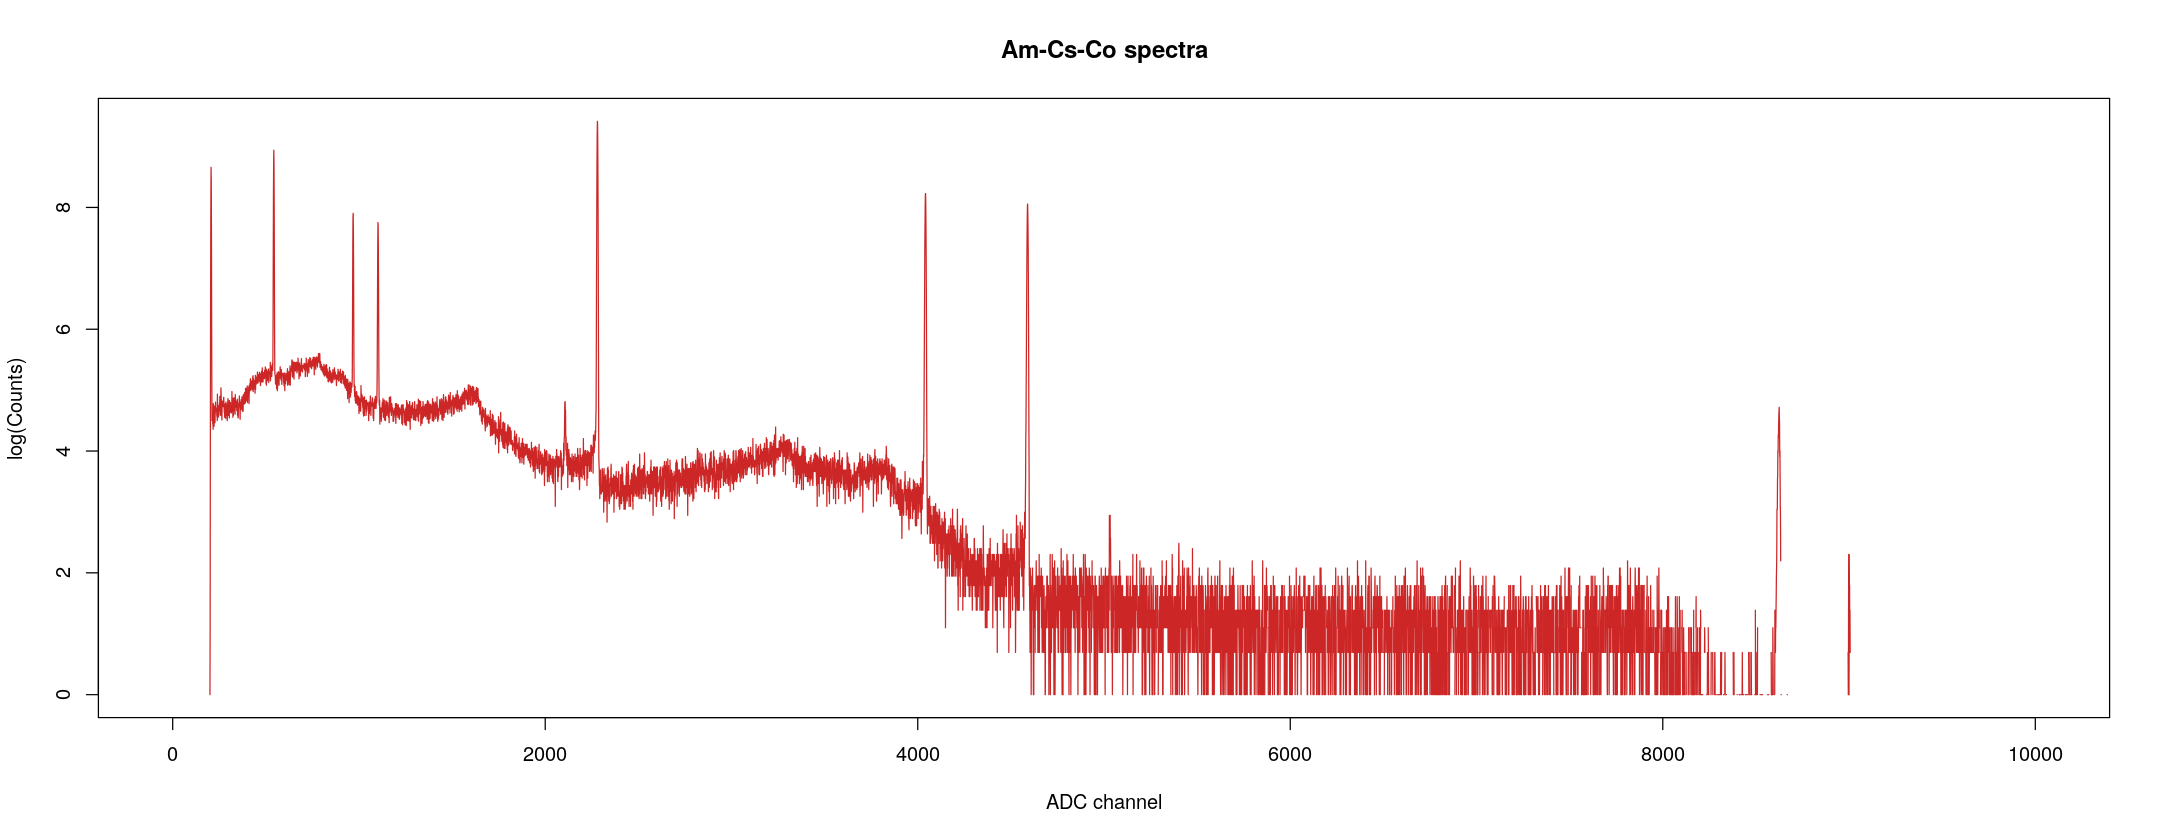

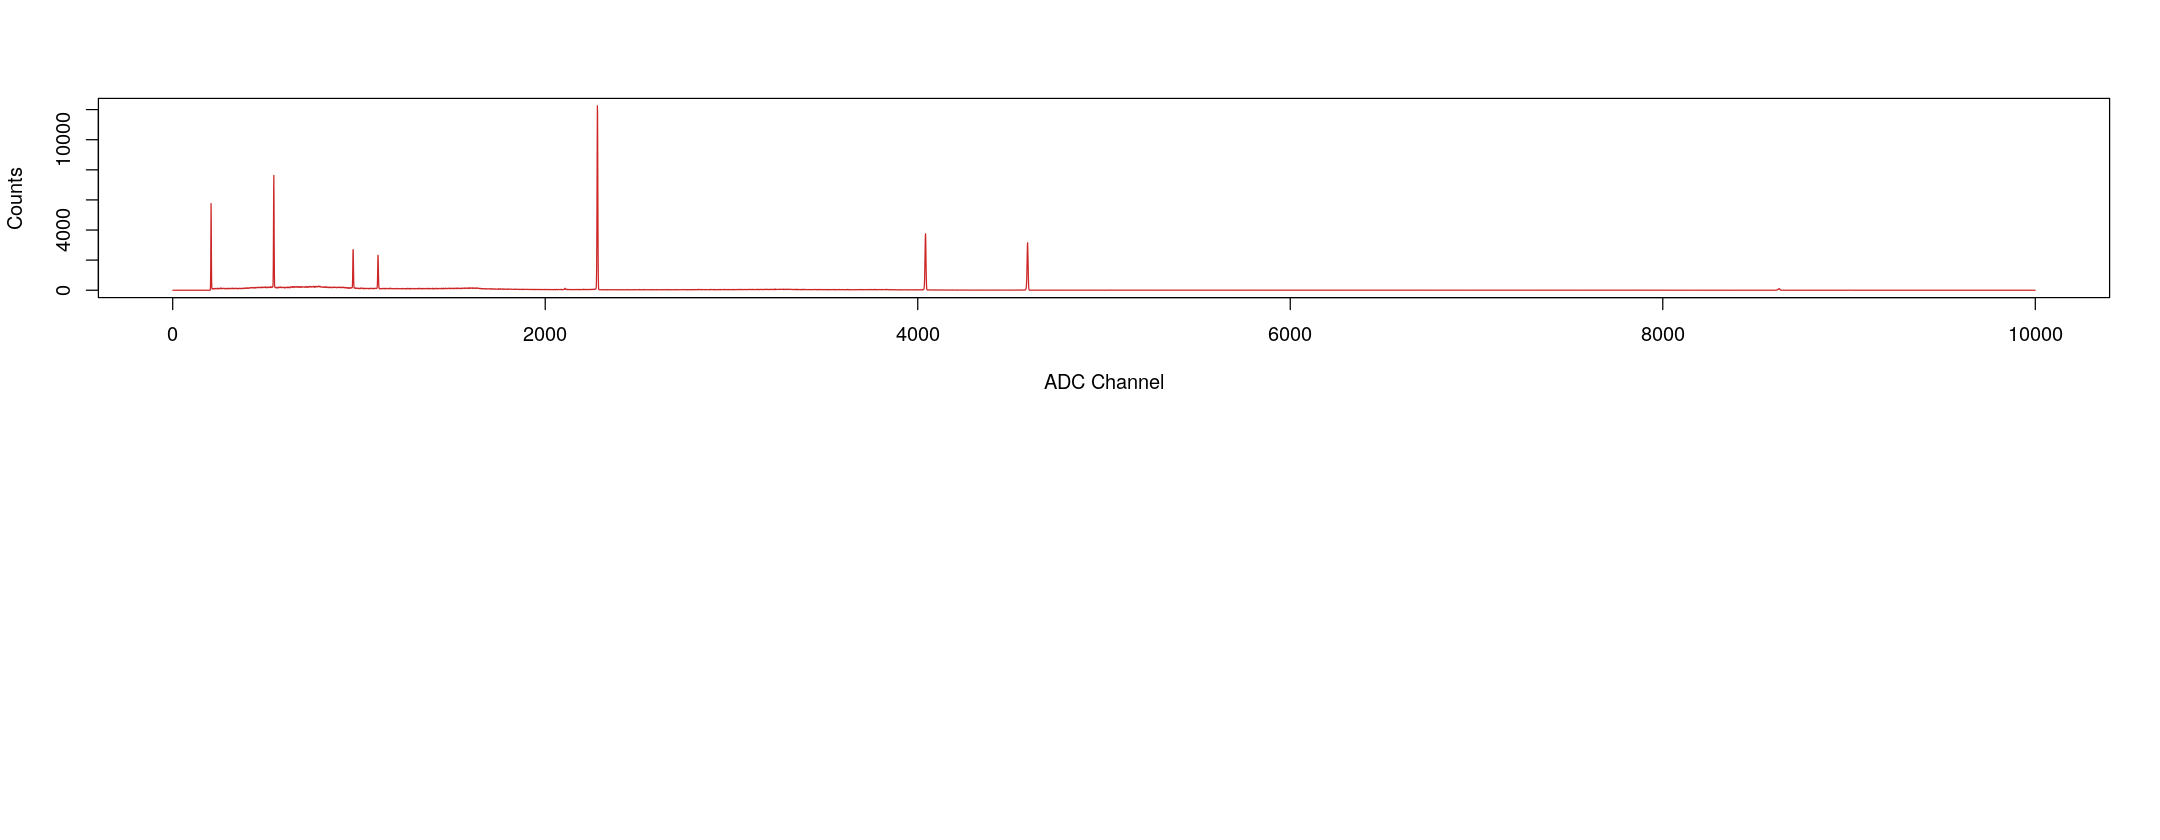

In [4]:
options(repr.plot.width=18, repr.plot.height=7)
plot(data$x, log(data$y),col='firebrick3',type='l',xlab="ADC channel",ylab="log(Counts)",
     main="Am-Cs-Co spectra")
par(mfrow=c(2,1))
plot(data$x, data$y,col='firebrick3',type='l',xlab="ADC Channel",ylab="Counts")

##  Inference of the centroids of each $\gamma$ peaks for all available sources  <a name="p1"></a>

The goal here is to infering the centroids (and the FWHM) of the 5 peaks running a rJAGS chain. We will then use the centroids to calibrate the detector and the FWHM to infere the Fano factor $F$.

### Model for the peaks
First of all for each of the 5 gaussian peaks we have to infere the $\mu$ and the $\sigma$.

We know that the counts $N_i$ follow a poisson distribution:
$$
\mathcal P(N_i|S_i) = \frac{S_i^{N_i}}{N_i!}e^{-S_i}
$$
where $S_i$ is the "real" signal. In our case $S_i$ is a gaussian :
$$
S_i = A\cdot \exp[{-\frac{(\mu-ADC_i)^2}{2\sigma^2}}] + B
$$.

Since we want to infere $\mu$ and the $\sigma$ we use the Bayes theorem with a Prior:
$$
P(\mu,\log\sigma,A,B|I) = \mathcal{U}_{[...]}
$$
and likelihood:
$$
P(\{N_i\}|\mu,\log\sigma,A,B,I) = \prod_{i=1}^N \mathcal P(N_i|S_i)
$$.

Now we isolate each peak and we infere the parameters $\mu$ and the $\sigma$ using a JAGS model.

In [5]:
signal <- function(x,A,B,mu,sigma){
    B+A*exp(-((x-mu)^2)/(2*sigma^2))
}

In [6]:
cat(" 
model { 
    # data likelihood 
    for (i in 1:length(N)) { 
        N[i] ~ dpois(S[i]);
        S[i] <- B+A*exp(-((X[i]-mu)^2)/(2*sigma^2));  
    } 
    # prior
    mu ~ dunif(150, 2500); 
    logsigma ~ dunif(-10,10); 
    sigma <- exp(logsigma)
    A ~ dunif(1000,15000); 
    B ~ dunif(0,1000); 
 
} 
",file = 'project.bug') 

In [7]:
JAGS.fit <- function(data,inits,nit,thin,burnin,title){
    jm <- jags.model(file = 'project.bug', inits = inits, data=data,quiet=TRUE,n.adapt=burnin)
    chain <- coda.samples(jm, c("A", "B", "mu",'sigma'), n.iter=nit,thin=thin) 
    print(summary(chain)$statistics)
    
    x <- data$X
    N <- data$N
    p <- summary(chain)$statistics[1:4] 

    options(repr.plot.width = 8, repr.plot.height = 6) 
    plot(x,N,lwd=2,col='blue',main=title,xlab='ADC (channel)',ylab='N')
    xx <- seq(min(x),max(x),0.1)
    lines(xx,signal(xx,p[1],p[2],p[3],p[4]),lwd =2,col='red',lty=2)
    legend("topright", legend=c("JAGS", "Gaussian peak"),
       col=c("blue", "red"), lty=1:2, cex=1)
    
    return (chain)
}

### Am

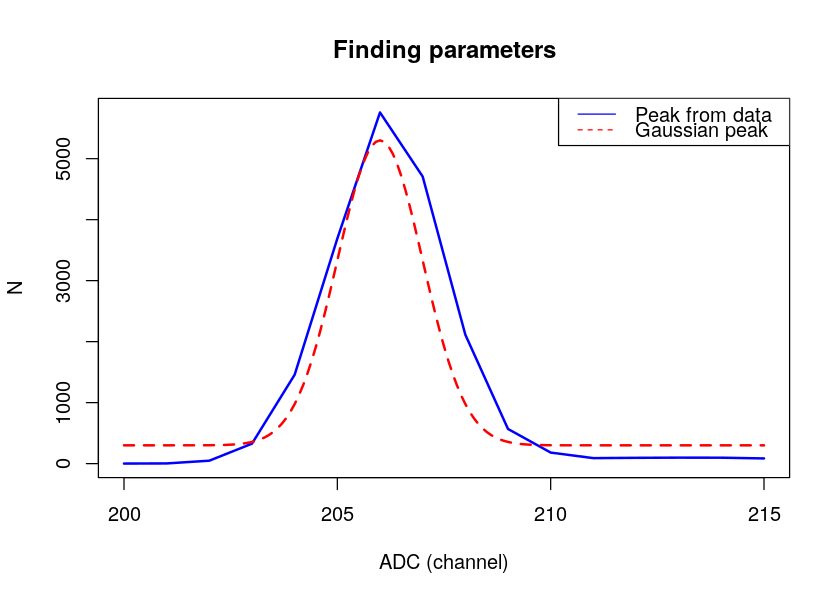

In [8]:
inf <- 200
sup <- 215

x <- adc[inf:sup]
N <- counts[inf:sup]

p <- c(5000,300,206,1)

options(repr.plot.width = 7, repr.plot.height = 5) 
plot(x,N,'l',lwd=2,col='blue',xlab='ADC (channel)',ylab='N',main='Finding parameters') 
xx <- seq(min(x),max(x),0.1)
lines(xx,signal(xx,p[1],p[2],p[3],p[4]),lwd =2,col='red',lty=2)
legend("topright", legend=c("Peak from data", "Gaussian peak"),
       col=c("blue", "red"), lty=1:2, cex=1)

In [9]:
sigma.fit <- c()
mu.fit <- c()


             Mean           SD     Naive SE Time-series SE
A     5672.593912 51.791906660 1.6378038941   1.6378038941
B       64.688523  3.043123546 0.0962320161   0.0962320161
mu     206.186689  0.009921205 0.0003137360   0.0003137360
sigma    1.285875  0.007988530 0.0002526195   0.0002526195


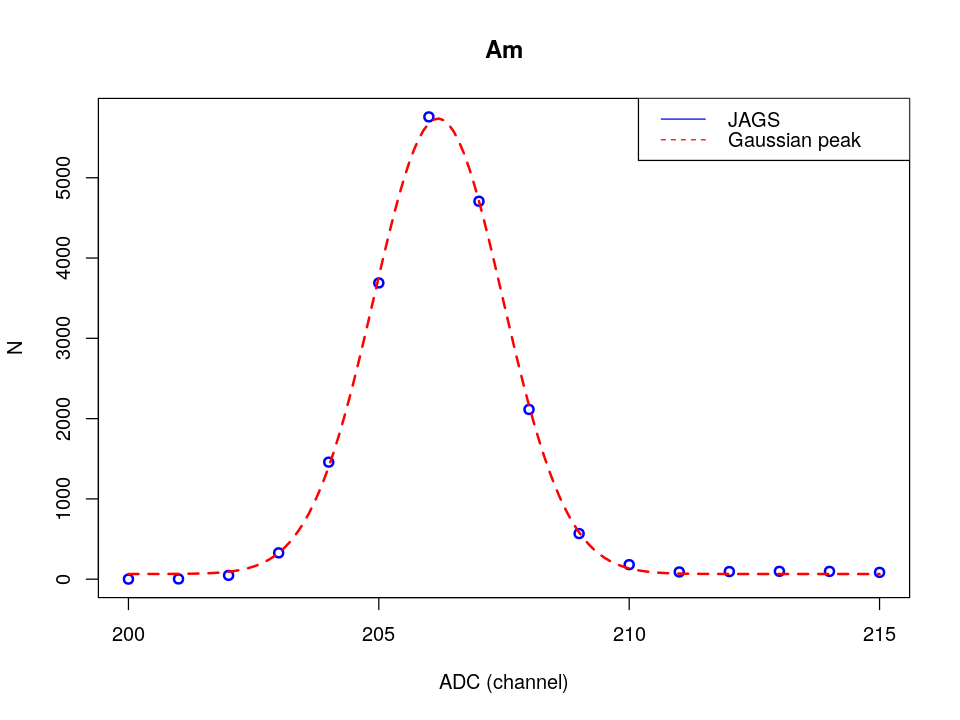

In [10]:
inits = list(   "mu" = 206,  
                "logsigma" = log(1),
                "A" = 5000,
                "B" = 300)
data1 = list(N = N,X = x) 

chain.am <- JAGS.fit(data1,inits,nit = 100000,thin = 100,burnin = 10000,title='Am')
sigma.fit <- append(sigma.fit, summary(chain.am)$statistics[4,1])
mu.fit <- append(mu.fit, summary(chain.am)$statistics[3,1])

### Cs

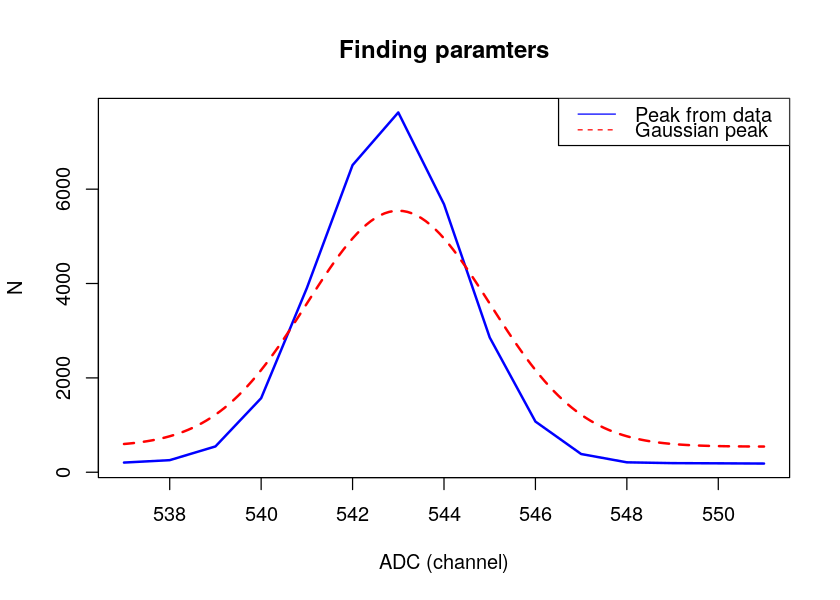

In [11]:
inf <- 537
sup <- 551

x <- adc[inf:sup]
N <- counts[inf:sup]

p <- c(5000,543,543,2)

options(repr.plot.width = 7, repr.plot.height = 5) 
plot(x,N,'l',lwd=2,col='blue',xlab='ADC (channel)',ylab='N',main='Finding paramters')
xx <- seq(min(x),max(x),0.1)
lines(xx,signal(xx,p[1],p[2],p[3],p[4]),lwd =2,col='red',lty=2)
legend("topright", legend=c("Peak from data", "Gaussian peak"),
       col=c("blue", "red"), lty=1:2, cex=1)

             Mean           SD     Naive SE Time-series SE
A     7380.186429 56.640706540 1.7911364095   1.7911364095
B      192.206855  6.082119979 0.1923335214   0.1923335214
mu     542.815837  0.009582595 0.0003030283   0.0003310464
sigma    1.541582  0.008782393 0.0002777236   0.0002777236


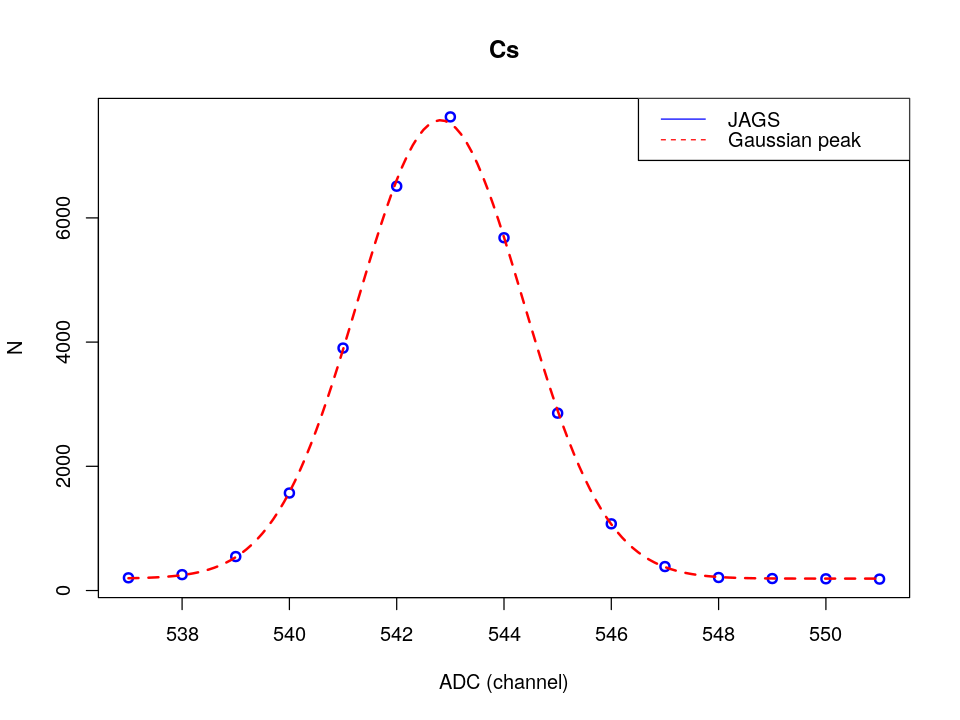

In [12]:
inits = list(   "mu" = 543,  
                "logsigma" = log(2),
                "A" = 5000,
                "B" = 300)
data1 = list(N = N,X = x) 

chain.cs <- JAGS.fit(data1,inits,nit = 100000,thin = 100,burnin = 10000,title='Cs')
sigma.fit <- append(sigma.fit, summary(chain.cs)$statistics[4,1])
mu.fit <- append(mu.fit, summary(chain.cs)$statistics[3,1])

### Co [1,2,3]

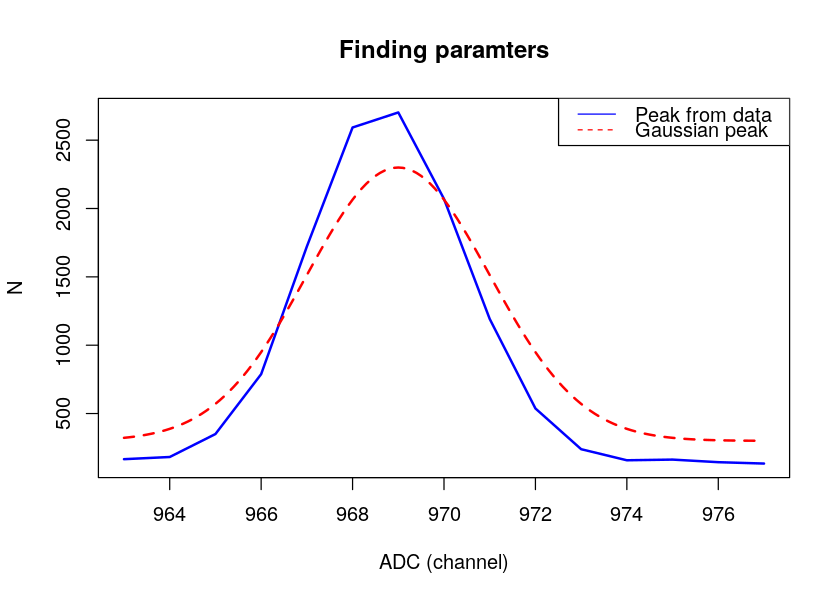

In [13]:
inf <- 963
sup <- 977

x <- adc[inf:sup]
N <- counts[inf:sup]

p <- c(2000,300,969,2)

options(repr.plot.width = 7, repr.plot.height = 5) 
plot(x,N,'l',lwd=2,col='blue',xlab='ADC (channel)',ylab='N',main='Finding paramters')
xx <- seq(min(x),max(x),0.1)
lines(xx,signal(xx,p[1],p[2],p[3],p[4]),lwd =2,col='red',lty=2)
legend("topright", legend=c("Peak from data", "Gaussian peak"),
       col=c("blue", "red"), lty=1:2, cex=1)

             Mean          SD     Naive SE Time-series SE
A     2639.560734 32.64305951 1.0322641785   0.9340769969
B      146.608076  5.17540956 0.1636608205   0.1636608205
mu     968.729194  0.01821422 0.0005759843   0.0005759843
sigma    1.654134  0.01642023 0.0005192532   0.0005192532


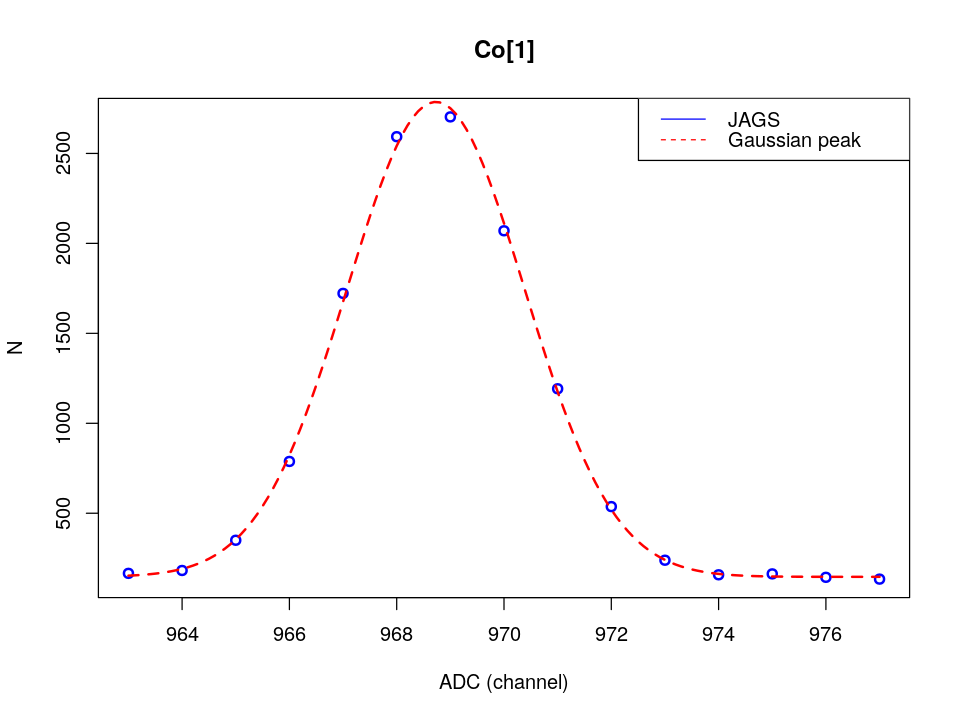

In [14]:
inits = list(   "mu" = 969,  
                "logsigma" = log(2),
                "A" = 2000,
                "B" = 300)
data1 = list(N = N,X = x) 

chain.co1 <- JAGS.fit(data1,inits,nit = 100000,thin = 100,burnin = 10000,title='Co[1]')
sigma.fit <- append(sigma.fit, summary(chain.co1)$statistics[4,1])
mu.fit <- append(mu.fit, summary(chain.co1)$statistics[3,1])

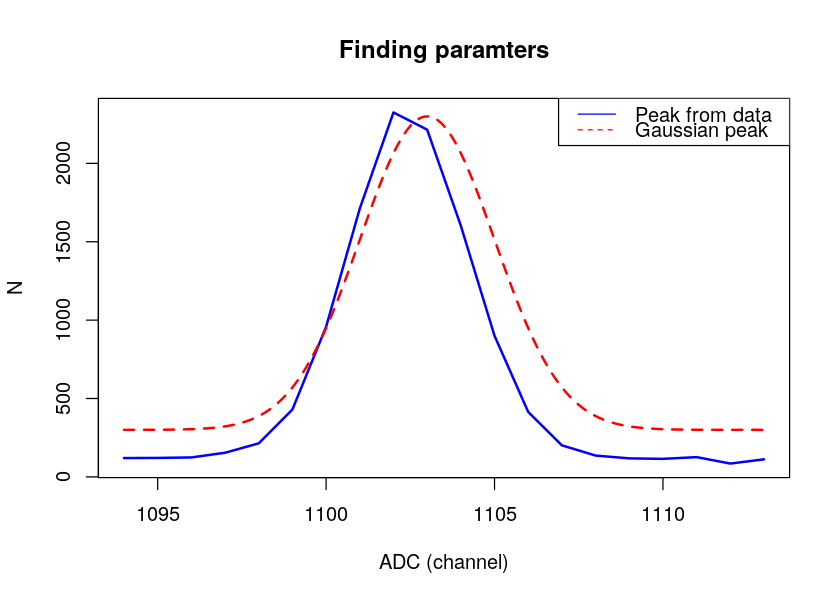

In [15]:
inf <- 1094
sup <- 1113

x <- adc[inf:sup]
N <- counts[inf:sup]

p <- c(2000,300,1103,2)

options(repr.plot.width = 7, repr.plot.height = 5) 
plot(x,N,'l',lwd=2,col='blue',xlab='ADC (channel)',ylab='N',main='Finding paramters')
xx <- seq(min(x),max(x),0.1)
lines(xx,signal(xx,p[1],p[2],p[3],p[4]),lwd =2,col='red',lty=2)
legend("topright", legend=c("Peak from data", "Gaussian peak"),
       col=c("blue", "red"), lty=1:2, cex=1)

             Mean          SD     Naive SE Time-series SE
A     2229.474609 28.40892160 0.8983689812   0.8983689812
B      117.196288  3.60039243 0.1138544055   0.1138544055
mu    1102.446819  0.01994582 0.0006307423   0.0005962719
sigma    1.761678  0.01750769 0.0005536419   0.0005536419


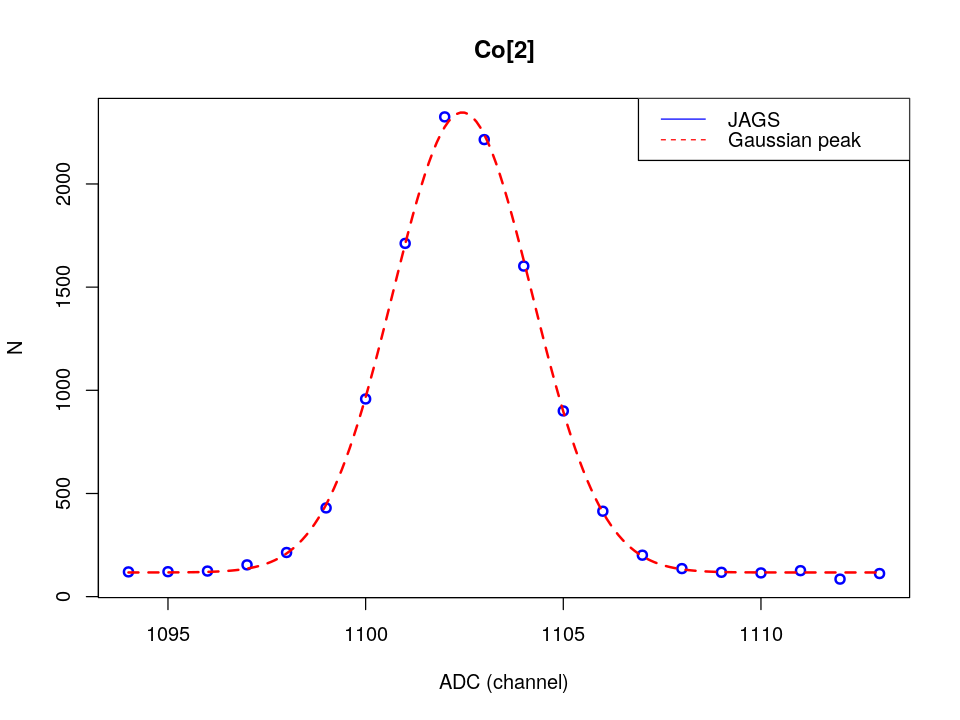

In [16]:
inits = list(   "mu" = 1103,  
                "logsigma" = log(2),
                "A" = 2000,
                "B" = 300)
data1 = list(N = N,X = x) 

chain.co2 <-JAGS.fit(data1,inits,nit = 100000,thin = 100,burnin = 10000,title='Co[2]')
sigma.fit <- append(sigma.fit, summary(chain.co2)$statistics[4,1])
mu.fit <- append(mu.fit, summary(chain.co2)$statistics[3,1])

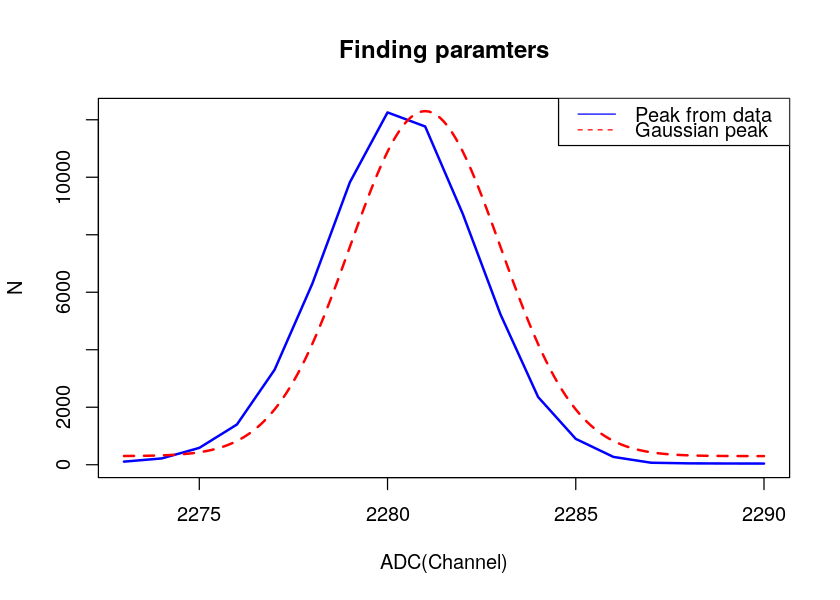

In [17]:
inf <- 2273
sup <- 2290

x <- adc[inf:sup]
N <- counts[inf:sup]

p <- c(12000,300,2281,2)

options(repr.plot.width = 7, repr.plot.height = 5) 
plot(x,N,'l',lwd=2,col='blue',xlab='ADC(Channel)',ylab='N',main='Finding paramters')
xx <- seq(min(x),max(x),0.1)
lines(xx,signal(xx,p[1],p[2],p[3],p[4]),lwd =2,col='red',lty=2)
legend("topright", legend=c("Peak from data", "Gaussian peak"),
       col=c("blue", "red"), lty=1:2, cex=1)

              Mean           SD     Naive SE Time-series SE
A     12180.573258 61.053009335 1.9306656751   2.1013543110
B        50.765165  3.729639592 0.1179415596   0.1179415596
mu     2280.296995  0.008350357 0.0002640615   0.0002150559
sigma     2.047556  0.006916008 0.0002187034   0.0002187034


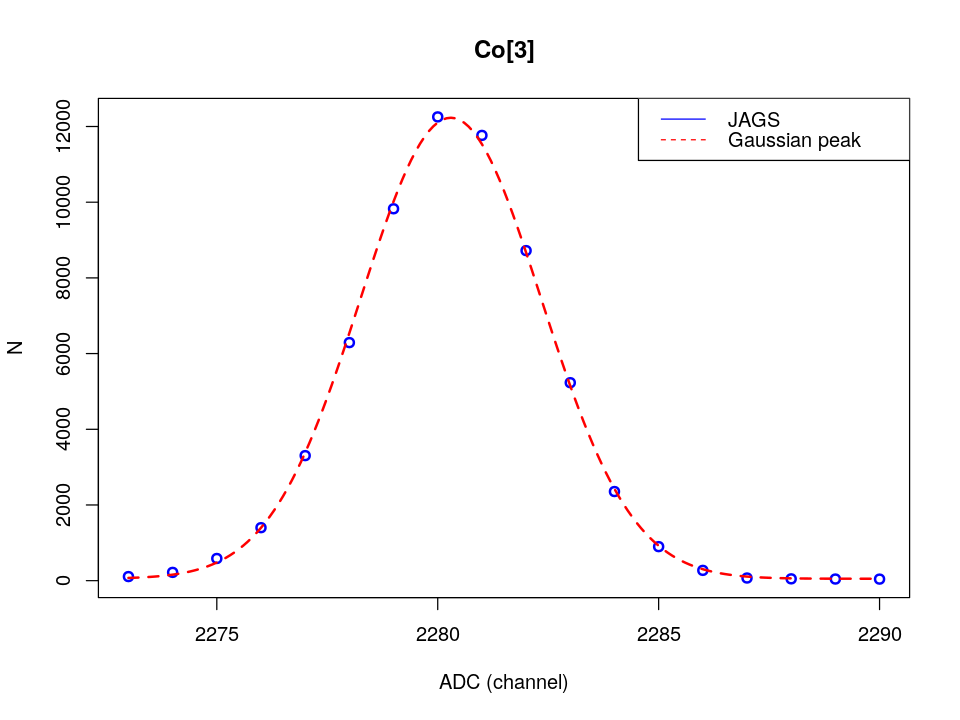

In [18]:
inits = list(   "mu" = 2281,  
                "logsigma" = log(2),
                "A" = 12000,
                "B" = 300)
data1 = list(N = N,X = x) 

chain.co3 <- JAGS.fit(data1,inits,nit = 100000,thin = 100,burnin = 10000,title='Co[3]')
sigma.fit <- append(sigma.fit, summary(chain.co3)$statistics[4,1])
mu.fit <- append(mu.fit, summary(chain.co3)$statistics[3,1])

## Energy calibration  <a name="p2"></a>

## Method 1: linear regression

Simple linear regression method already implemented in R

In [19]:
# energy (keV)
en <- c(59.5409, 661.657, 1173.228, 1332.492, 2505.69)

#peaks in ADC
#mu.fit

In [20]:
df <- data.frame(Energy=en,x0=mu.fit)
rownames(df) <- c("Am-241", "Cs-137", "C0-60.1","C0-60.2", "C0-60.3")
df

,Energy,x0
,<dbl>,<dbl>
Am-241,59.5409,206.1867
Cs-137,661.6570,542.8158
C0-60.1,1173.2280,968.7292
C0-60.2,1332.4920,1102.4468
C0-60.3,2505.6900,2280.2970


In [21]:
# The relation between ADC and Energy(keV) is considered to be linear of the form y=mx+c.
# lm() in R is a good tool to model them.
regression <- lm(formula =   df$x0 ~ df$Energy)
regression

# Extracting coefficients
m <- regression$coefficients[2]
q <- regression$coefficients[1]
a <- (1/m)
b <- (-q/m)

# changing adc channel axis to -->> to kev
# Energy is now simply obtained using the relation y=mx+c
energy <- a*data$x + b
cat('a:',a,'\n')
cat('b:',b)


Call:
lm(formula = df$x0 ~ df$Energy)

Coefficients:
(Intercept)    df$Energy  
    32.1660       0.8617  


a: 1.16053 
b: -37.32957

Given a linear response we calculate the $a$,$b$ parameters of the regression

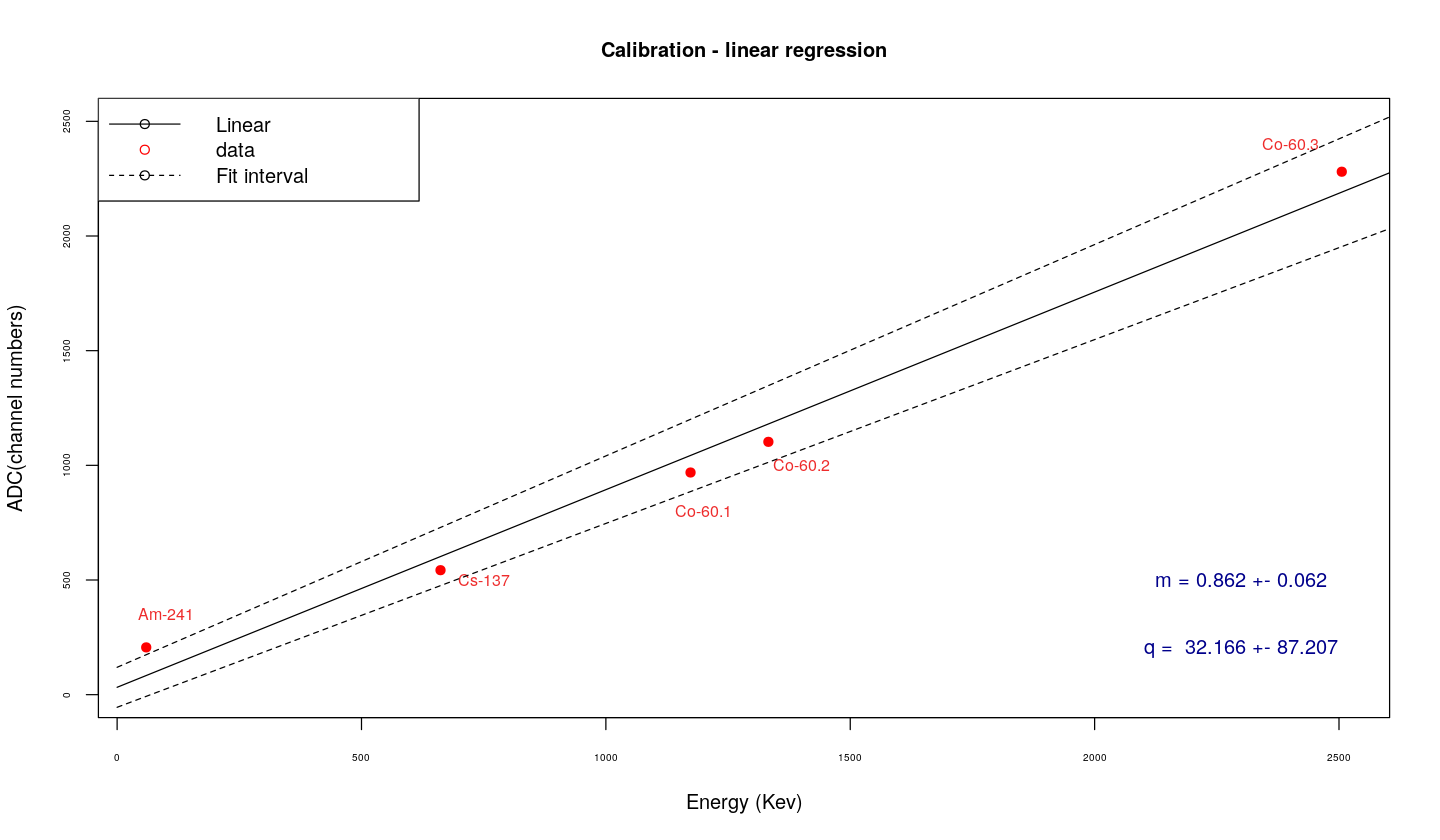

In [22]:
options(repr.plot.width=12, repr.plot.height=7)
plot(df$Energy, df$x0, col="red", pch=20, cex=1.5, xlab="Energy (Kev)",
     ylab="ADC(channel numbers)",ylim=c(0,2500), main='Calibration - linear regression',
     cex.main=1 ,yaxt="n",xaxt="n",cex.lab=1)
text(2300,500,paste('m =',round(m,3),'+-',0.062), col='darkblue')
text(2300,200,paste('q = ',round(q,3),'+-',87.207), col='darkblue')
text(100,350,'Am-241',cex=0.8, col='firebrick2')
text(750,500,'Cs-137',cex=0.8, col='firebrick2')
text(1200,800,'Co-60.1',cex=0.8, col='firebrick2')
text(1400,1000,'Co-60.2',cex=0.8, col='firebrick2')
text(2400,2400,'Co-60.3',cex=0.8, col='firebrick2')
axis(2,cex.axis=0.5)
axis(1,cex.axis=0.5)
x <- seq(0,4000,1)
y1 <- (m-0.06)*x + q-87.2
y <- m*x +q
y2 <- (m+0.06)*x +q+87.2
lines(x,y, lty=1)
lines(x,y1, lty=2)
lines(x,y2, lty=2)

legend('topleft', legend=c('Linear','data','Fit interval'),
       col=c('black','red','black'), pch=c(NULL,1,NULL), lty=c(1,0,2))

In [23]:
# function to plot the results with line
emission.lines <- function(vec){
    nuclides <- c("Am-241","Cs-137","Co-60.1","Co-60.2","Co-60.3")
    i=0
    for (line in vec){
        i=i+1
        abline(v=line, col="blue", lty=2, lwd=1)
        text(line,4,paste(nuclides[i]," ",round(line,2)),srt=90,cex=1.4)      
    }
}


lines.only <- function(vec){
    nuclides <- c("Am-241","Cs-137","Co-60.1","Co-60.2","Co-60.3")
    i=0
    for (line in vec){
        i=i+1
        abline(v=line, col="blue", lty=2, lwd=1)
    }
}

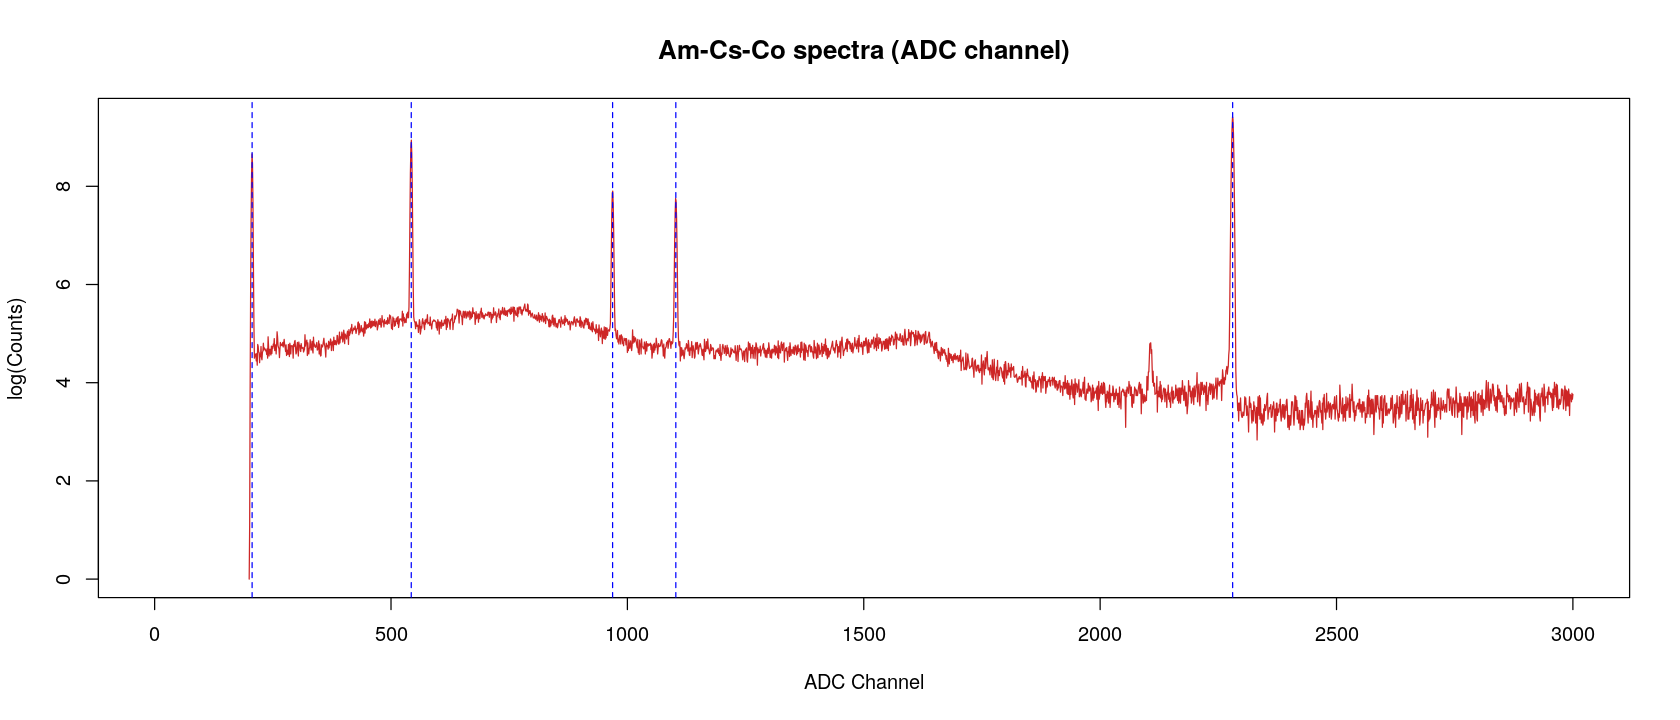

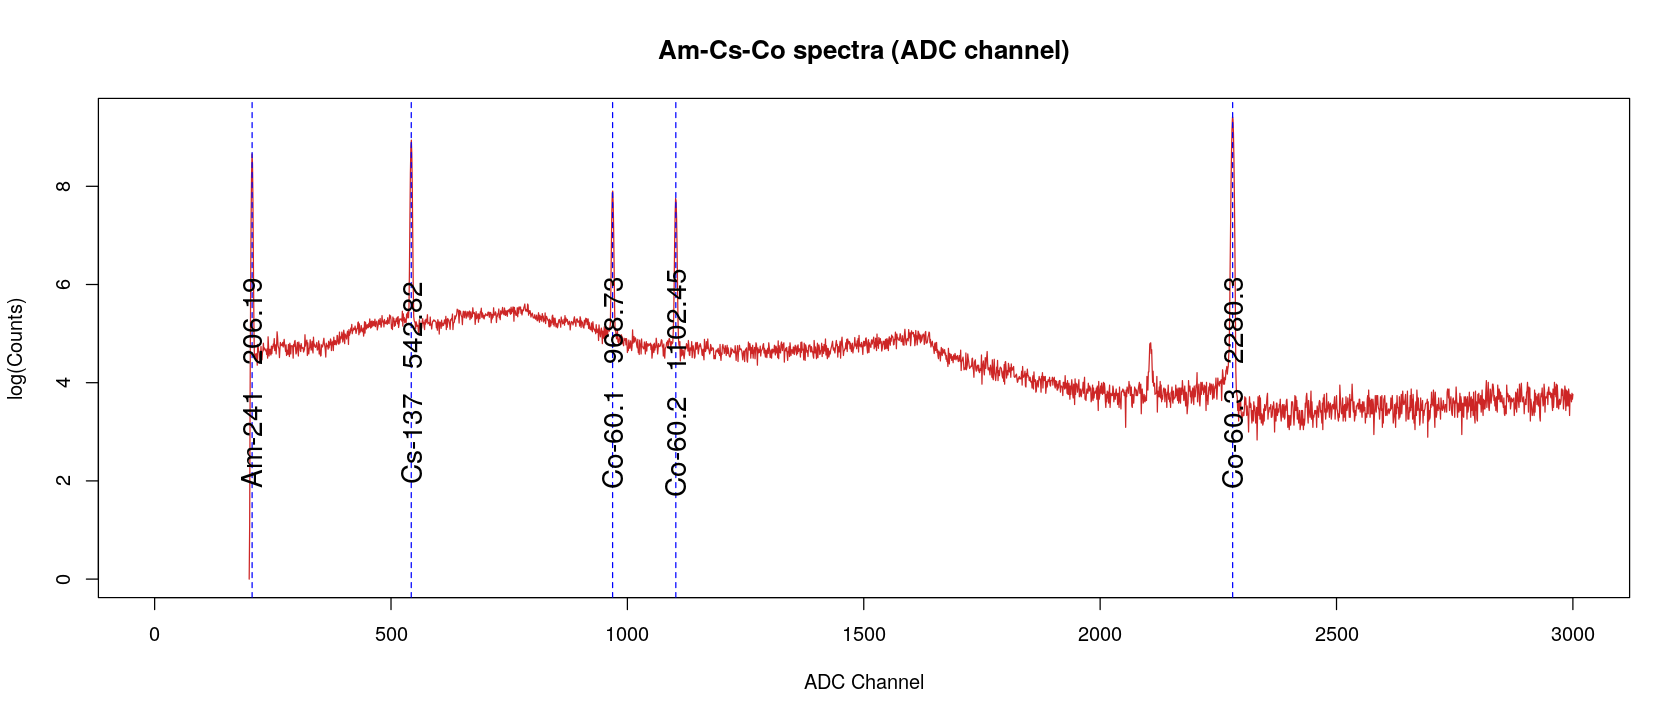

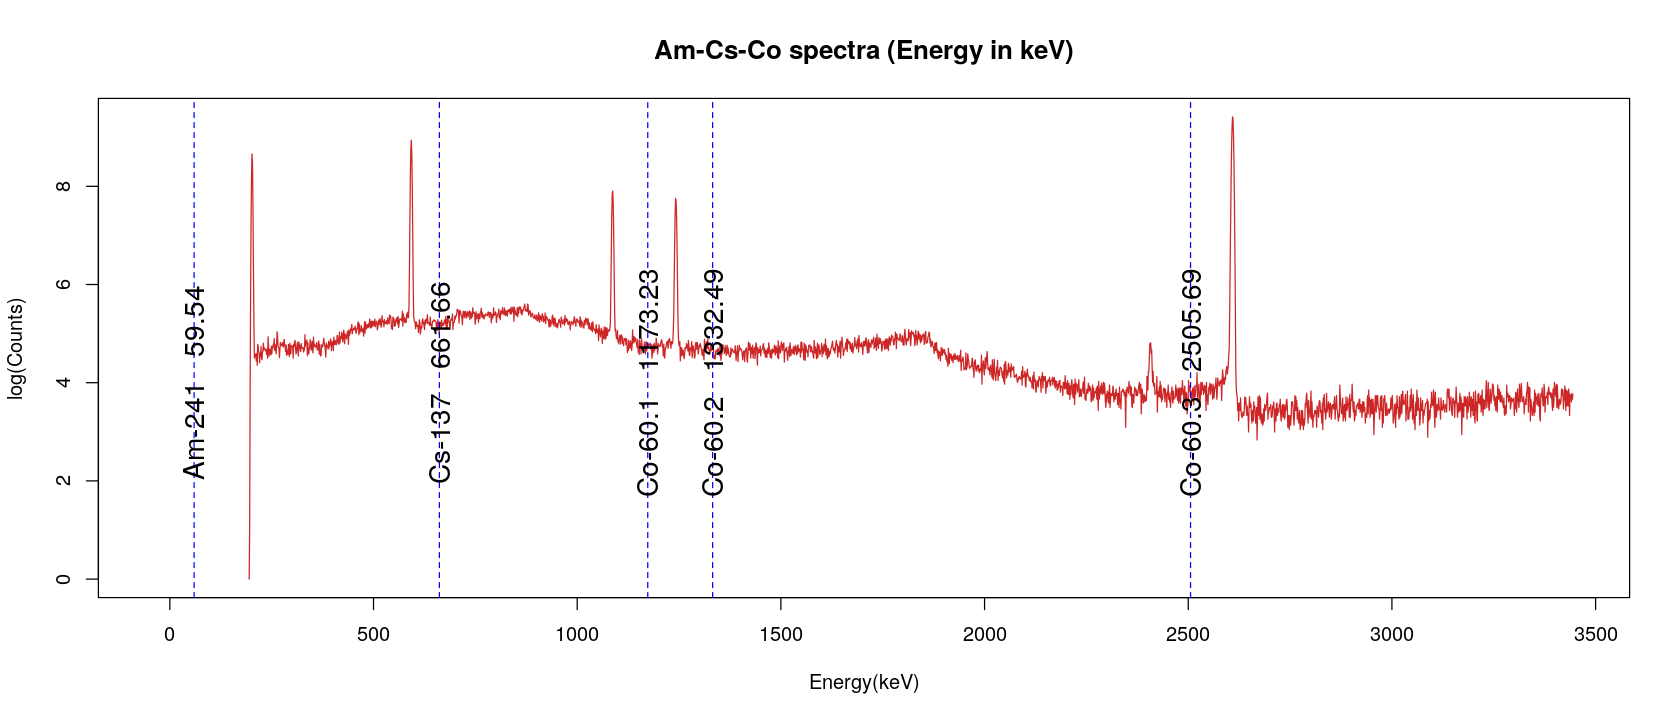

In [24]:
# log plots comparison, the one with x axis as ADC channel numbers and the other with x axis as Energy(keV)
options(repr.plot.width=14, repr.plot.height=6)

plot(data$x[1:3000], log(data$y)[1:3000],col='firebrick3',type='l',xlab="ADC Channel",ylab="log(Counts)",
     main="Am-Cs-Co spectra (ADC channel)",cex.main=1.3,cex.lab=1,yaxt="n",xaxt="n")
axis(2,cex.axis=1)
axis(1,cex.axis=1)
lines.only(df$x0)


plot(data$x[1:3000], log(data$y)[1:3000],col='firebrick3',type='l',xlab="ADC Channel",ylab="log(Counts)",
     main="Am-Cs-Co spectra (ADC channel)",cex.main=1.3,cex.lab=1,yaxt="n",xaxt="n")
axis(2,cex.axis=1)
axis(1,cex.axis=1)
emission.lines(df$x0)


plot(energy[1:3000], log(data$y)[1:3000],col='firebrick3',type='l',xlab="Energy(keV)",ylab="log(Counts)",
     main="Am-Cs-Co spectra (Energy in keV)",cex.main=1.3,cex.lab=1,yaxt="n",xaxt="n")
axis(2,cex.axis=1)
axis(1,cex.axis=1)
emission.lines(df$Energy)

As we see the method doesn't fit perfectly the data, this is given to the very high error on the $b$ parameter as the data is not noisless

## Method 2: JAGS

Linear regression using rjags, model: 
$$y_i=ax_i+b+\epsilon_i$$ 
where $\epsilon_i$ is distributed as a gaussian with $\mu_i = 0$ and $\sigma_i =\sigma\cdot x_i$.
The last assumption is due to the linear relation between the real signal and the adc. 

In this case the likelihood is:
$$
P({y_i}|\sigma,a,b,{x_i},I) = \prod_i\mathcal N (x=(y_i-x_i\cdot a - b),\mu=0,\sigma=\sigma)
$$
and the prior is uniform:
$$
P(\arctan(a),b,\log(\sigma)|I) = \mathcal U_{[...]}
$$.

In [25]:
#data
df

,Energy,x0
,<dbl>,<dbl>
Am-241,59.5409,206.1867
Cs-137,661.6570,542.8158
C0-60.1,1173.2280,968.7292
C0-60.2,1332.4920,1102.4468
C0-60.3,2505.6900,2280.2970


In [26]:
data <- NULL
data$X <- df$Energy
data$Y <- df$x0
data$eps <- sigma.fit
data

$X
[1]   59.5409  661.6570 1173.2280 1332.4920 2505.6900

$Y
[1]  206.1867  542.8158  968.7292 1102.4468 2280.2970

$eps
[1] 1.285875 1.541582 1.654134 1.761678 2.047556

We know that $a>0$ and that the noise (looking at the data) is very little.
To exploit the statistical functionality of rjags we also predict a new (fake) peak to show how much error we have in the prediction.

In [27]:
cat("model {

    # data likelihood
    for (i in 1:5){
        Y[i] ~ dnorm(mu[i],1/(eps[i]));
        mu[i] <- q + m*X[i];
    }

    #priors
    alpha ~ dunif(0,2);
    m <- tan(alpha)
    q ~ dunif(-100,100);
    
    a <- 1/m;
    b <- -q/m;

    #predictions
    x_in <- 2000 #in adc
    x_out <- 5000
    y_1 <- q + m*x_in;
    y_2 <- q + m*x_out;

}", file='method2.bug')


init <- NULL
init$alpha <- pi/4
init$q <- -4

In [28]:
jm <- jags.model(file='method2.bug',data, init=init)
update(jm,4000)
chain <- coda.samples(jm, c('a','b','y_1','y_2','m','q'), n.iter=2e5, thin=200)
print(summary(chain))

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 5
   Unobserved stochastic nodes: 2
   Total graph size: 47

Initializing model


Iterations = 5200:205000
Thinning interval = 200 
Number of chains = 1 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

         Mean        SD  Naive SE Time-series SE
a      1.1845 0.0009905 3.132e-05      3.136e-05
b    -63.5966 1.1051540 3.495e-02      4.615e-02
m      0.8442 0.0007060 2.232e-05      2.235e-05
q     53.6899 0.8974387 2.838e-02      3.770e-02
y_1 1742.1623 0.9030364 2.856e-02      2.598e-02
y_2 4274.8708 2.8820949 9.114e-02      8.594e-02

2. Quantiles for each variable:

         2.5%       25%       50%       75%     97.5%
a      1.1826    1.1838    1.1845    1.1852    1.1864
b    -65.7912  -64.3462  -63.5869  -62.8683  -61.4367
m      0.8429    0.8437    0.8442    0.8447    0.8456


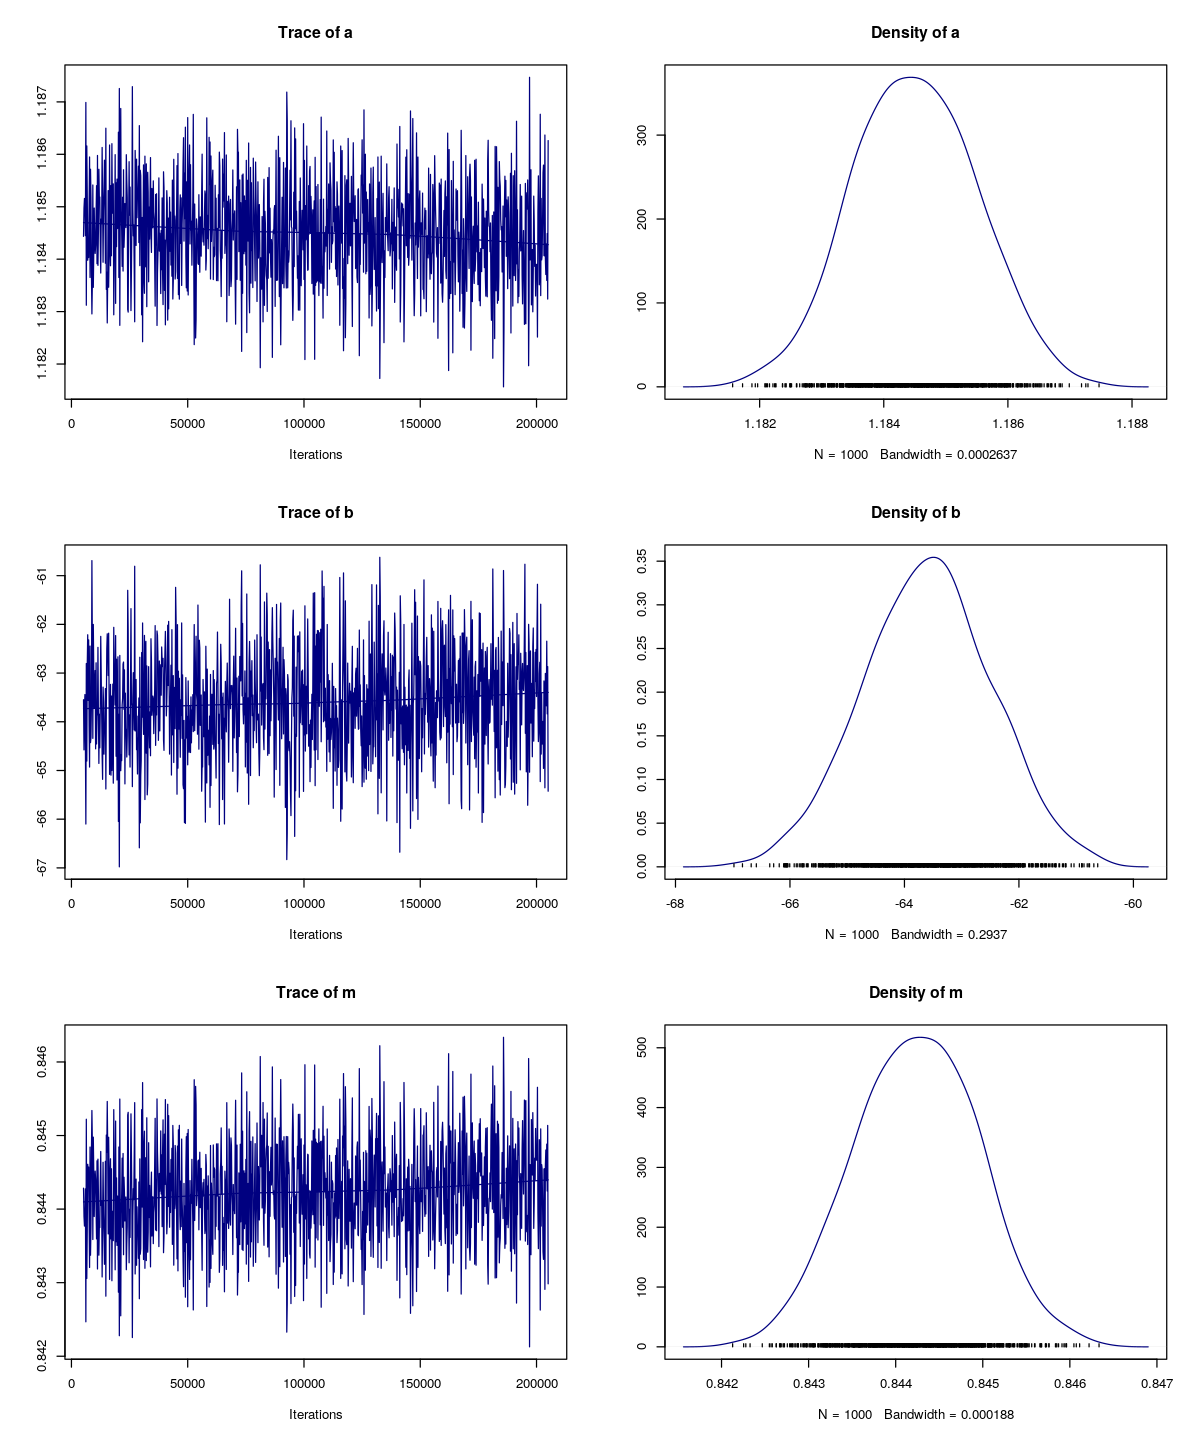

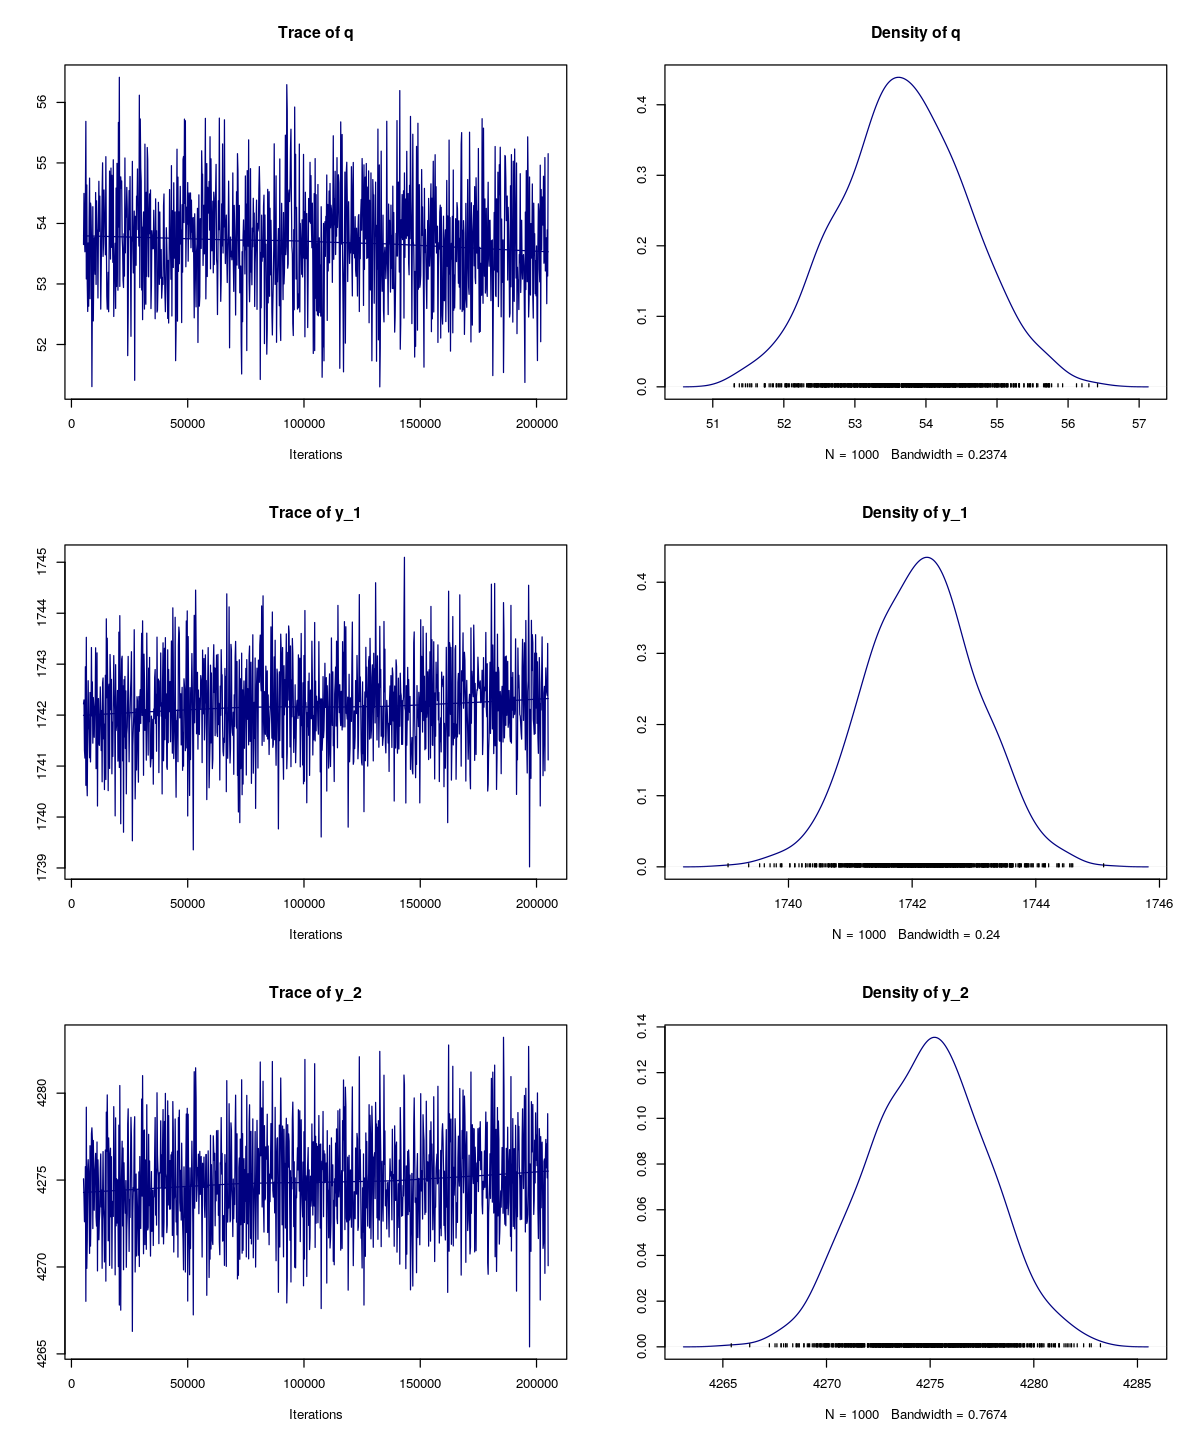

In [29]:
options(repr.plot.width=10, repr.plot.height=12)
plot(chain , col="navy")

In [30]:
sch <- summary(chain)
round(sch$statistics[,1:2],4)

,Mean,SD
a,1.1845,0.0010
b,-63.5966,1.1052
m,0.8442,0.0007
q,53.6899,0.8974
y_1,1742.1623,0.9030
y_2,4274.8708,2.8821


In [31]:
sch$quantiles

#so the 95% cred interval is 2.5%-97.5%
cat('95% cred. interval: \n')
cat('a: ',sch$quantiles[1,1],'-',sch$quantiles[1,5],'\n')
cat('b: ',sch$quantiles[2,1],'-',sch$quantiles[2,5],'\n')
cat('m: ',sch$quantiles[3,1],'-',sch$quantiles[3,5],'\n')
cat('q: ',sch$quantiles[4,1],'-',sch$quantiles[4,5],'\n')
cat('y_1: ',sch$quantiles[5,1],'-',sch$quantiles[5,5],'\n')
cat('y_2: ',sch$quantiles[6,1],'-',sch$quantiles[6,5])

,2.5%,25%,50%,75%,97.5%
a,1.1825999,1.1837984,1.1845051,1.1851858,1.1864442
b,-65.7912143,-64.3461943,-63.5869389,-62.8682730,-61.4367363
m,0.8428546,0.8437495,0.8442344,0.8447384,0.8455945
q,51.9331036,53.1069617,53.6767291,54.3018263,55.4744702
y_1,1740.4233251,1741.5429469,1742.1563881,1742.7508998,1743.8895380
y_2,4269.4534472,4272.8552576,4274.9374656,4276.8197607,4280.4946430


95% cred. interval: 
a:  1.1826 - 1.186444 
b:  -65.79121 - -61.43674 
m:  0.8428546 - 0.8455945 
q:  51.9331 - 55.47447 
y_1:  1740.423 - 1743.89 
y_2:  4269.453 - 4280.495

In [32]:
a <- sch$statistics[1,1]
b <- sch$statistics[2,1]
m <- sch$statistics[3,1]
q <- sch$statistics[4,1]
y_1 <- sch$statistics[5,1]
y_2 <- sch$statistics[6,1]
a.jags <- a

Warning message in arrows(x, li, x, pmax(y - gap, li), col = barcol, lwd = lwd, :
“zero-length arrow is of indeterminate angle and so skipped”
Warning message in arrows(x, ui, x, pmin(y + gap, ui), col = barcol, lwd = lwd, :
“zero-length arrow is of indeterminate angle and so skipped”


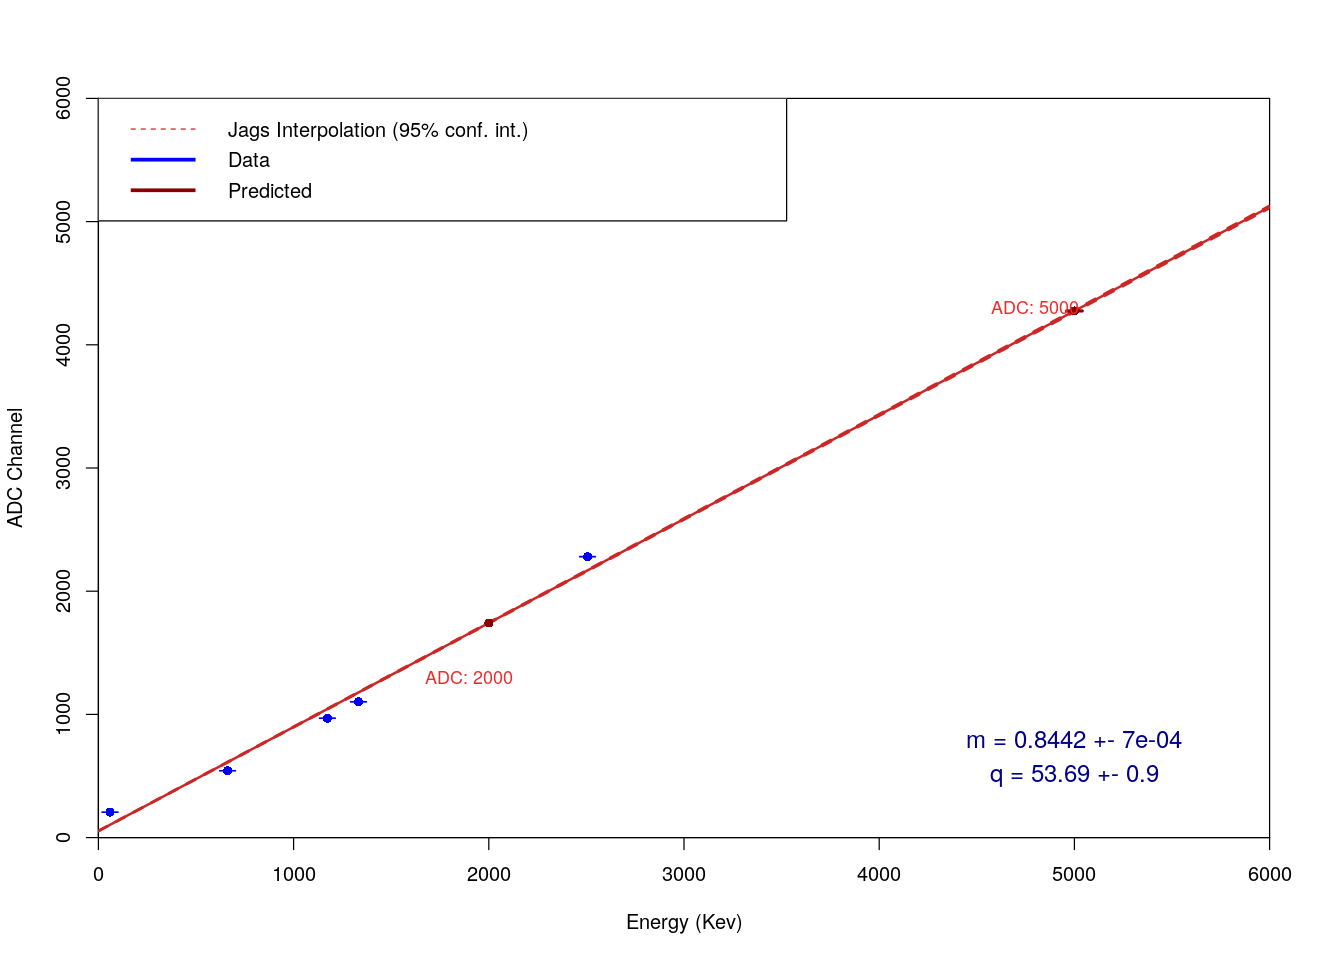

In [33]:
options(repr.plot.width=11, repr.plot.height=8)
plotCI(data$X, data$Y, xlim=c(0,6000), ylim=c(0,6000), xaxs="i", yaxs="i",ylab="ADC Channel",xlab="Energy (Kev)",
       uiw=sigma.fit, gap=0, col='blue',pch=16)
abline(a=q, b=m, lw=2, col='firebrick3')
abline(a=sch$quantiles[4,1], b=sch$quantiles[3,1], lw=2, col='firebrick3',lty=2)
abline(a=sch$quantiles[4,5], b=sch$quantiles[3,5], lw=2, col='firebrick3',lty=2)
plotCI(x_in <-2000 , y_1, uiw = sch$statistics[5,2], gap=0, add=TRUE ,lwd=2, col='darkred',xaxt="n",pch=16)
plotCI(x_out <-5000 , y_2, uiw = sch$statistics[6,2], gap=0, add=TRUE ,lwd=2, col='darkred', xaxt="n",pch=16)
text(1900,1300,paste('ADC:',x_in), col='firebrick2',cex=0.9)
text(4800,4300,paste('ADC:',x_out), col='firebrick2', cex=0.9)
text(5000,800,paste('m =',round(m,4),'+-',round(sch$statistics[3,2],4)), col='darkblue',cex=1.2)
text(5000,500,paste('q =',round(q,2),'+-',round(sch$statistics[4,2],2)), col='darkblue',cex=1.2)
legend('topleft', legend=c('Jags Interpolation (95% conf. int.)','Data','Predicted'), 
       col=c('firebrick3','blue','darkred'),lty=c(2,1,1),lwd=c(1,3,3))

As we can see from the plot, predicting an high energy $\gamma$ is much more difficult since the error scales with the energy as we expect. Also the graph represents Energy Vs ADC channels this is due to the different errors input in jags w.r.t. x and y

The next plot shows how JAGS predicts much better the first peaks instead of the last ones.

In [34]:
energy <- a*adc.df$ADC +b

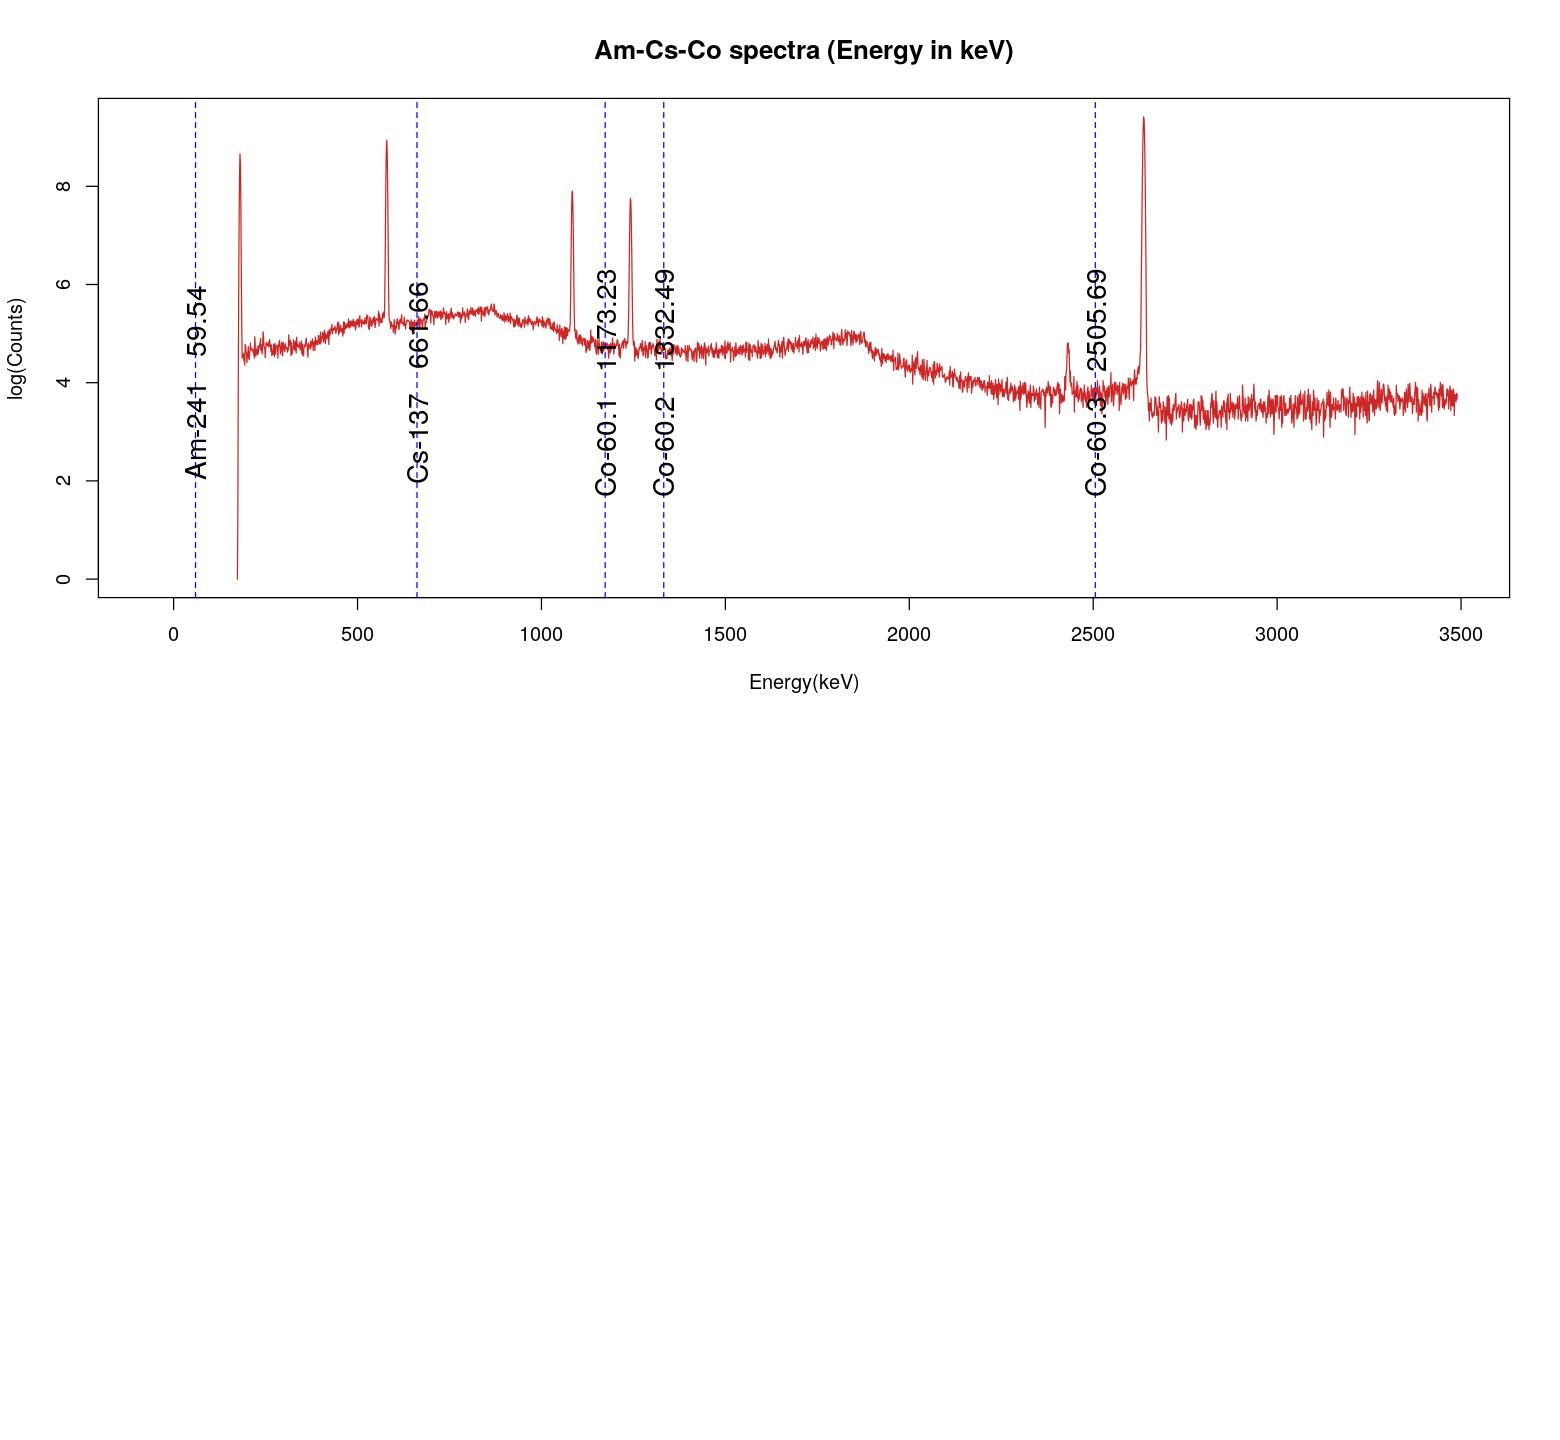

In [35]:
# log plots comparison, the one with x axis as ADC channel numbers and the other with x axis as Energy(keV)
options(repr.plot.width=13, repr.plot.height=12)
par(mfrow=c(2,1))
plot(energy[0:3000], log(adc.df$counts)[0:3000],col='firebrick3',type='l',xlab="Energy(keV)",ylab="log(Counts)",
     main="Am-Cs-Co spectra (Energy in keV)",cex.main=1.3,cex.lab=1,yaxt="n",xaxt="n")
axis(2,cex.axis=1)
axis(1,cex.axis=1)
emission.lines(df$Energy)

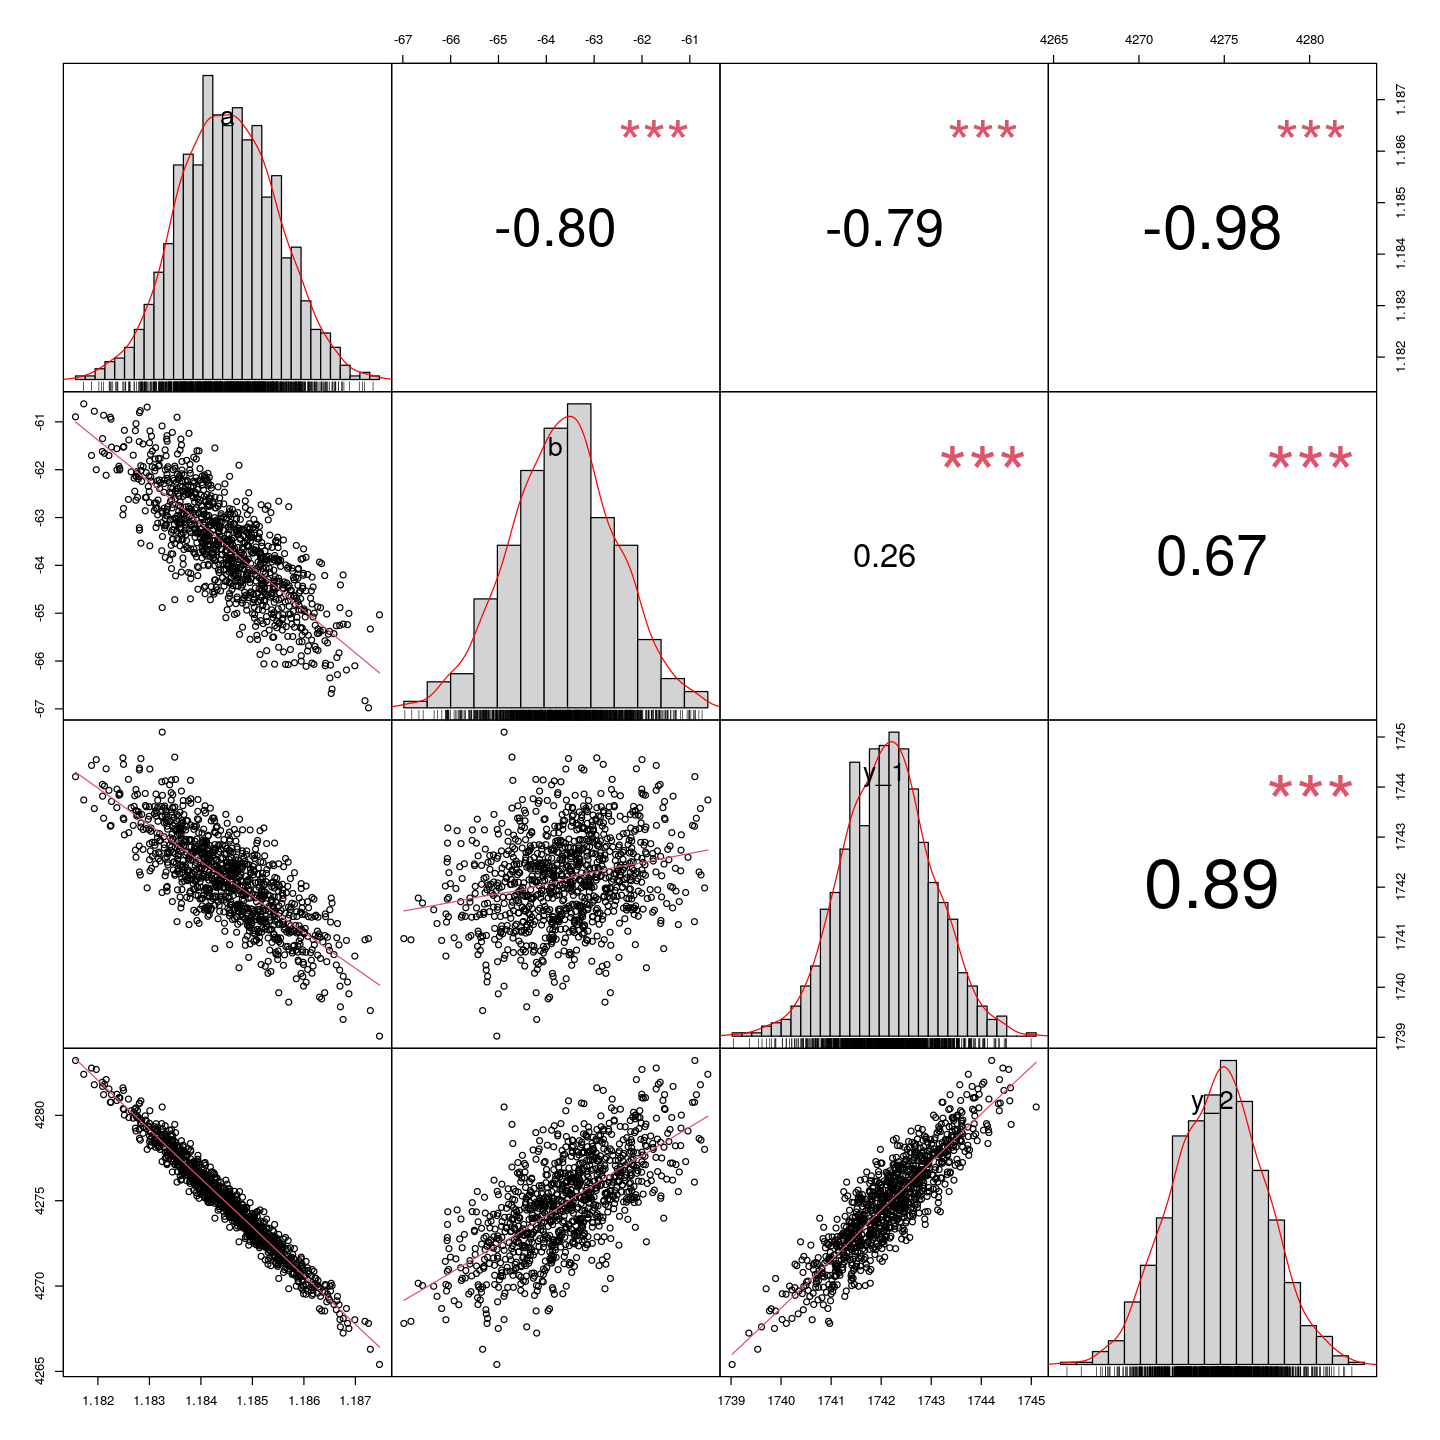

In [36]:
options(repr.plot.width=12, repr.plot.height=12)
chain.df <- as.data.frame(as.mcmc(chain))
chain.df <- chain.df[,c('a','b','y_1','y_2')]
chart.Correlation(chain.df, histogram = T, pch= 19)

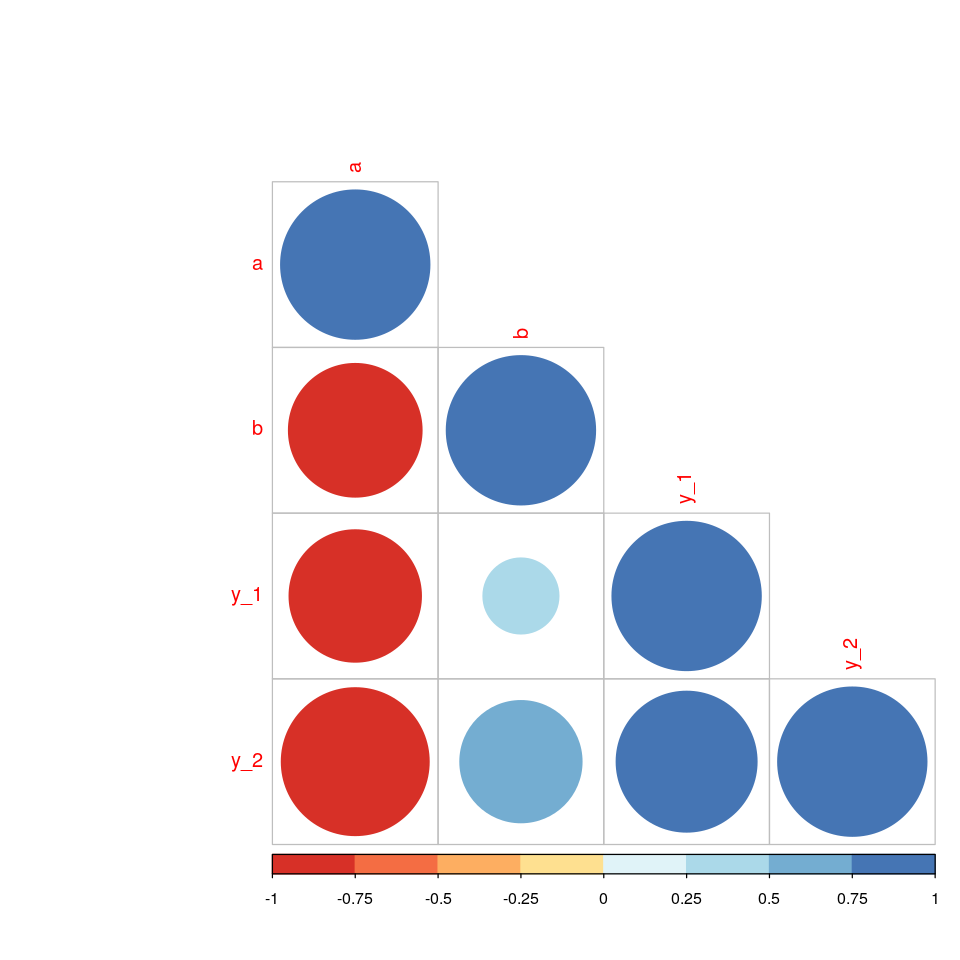

In [37]:
options(repr.plot.width=8, repr.plot.height=8)
M <-cor(chain.df)
corrplot(M, type="lower", order="hclust",
         col=brewer.pal(n=8, name="RdYlBu"))

#### Correlation plot

As we can see the autocorrelation tends to zero very quickly with all values of the burn-in (the initial part of the chain that we "cut"). This Bayesian analysis is very good because our infered parameters won't depend on the correlation of the Markov chain. 

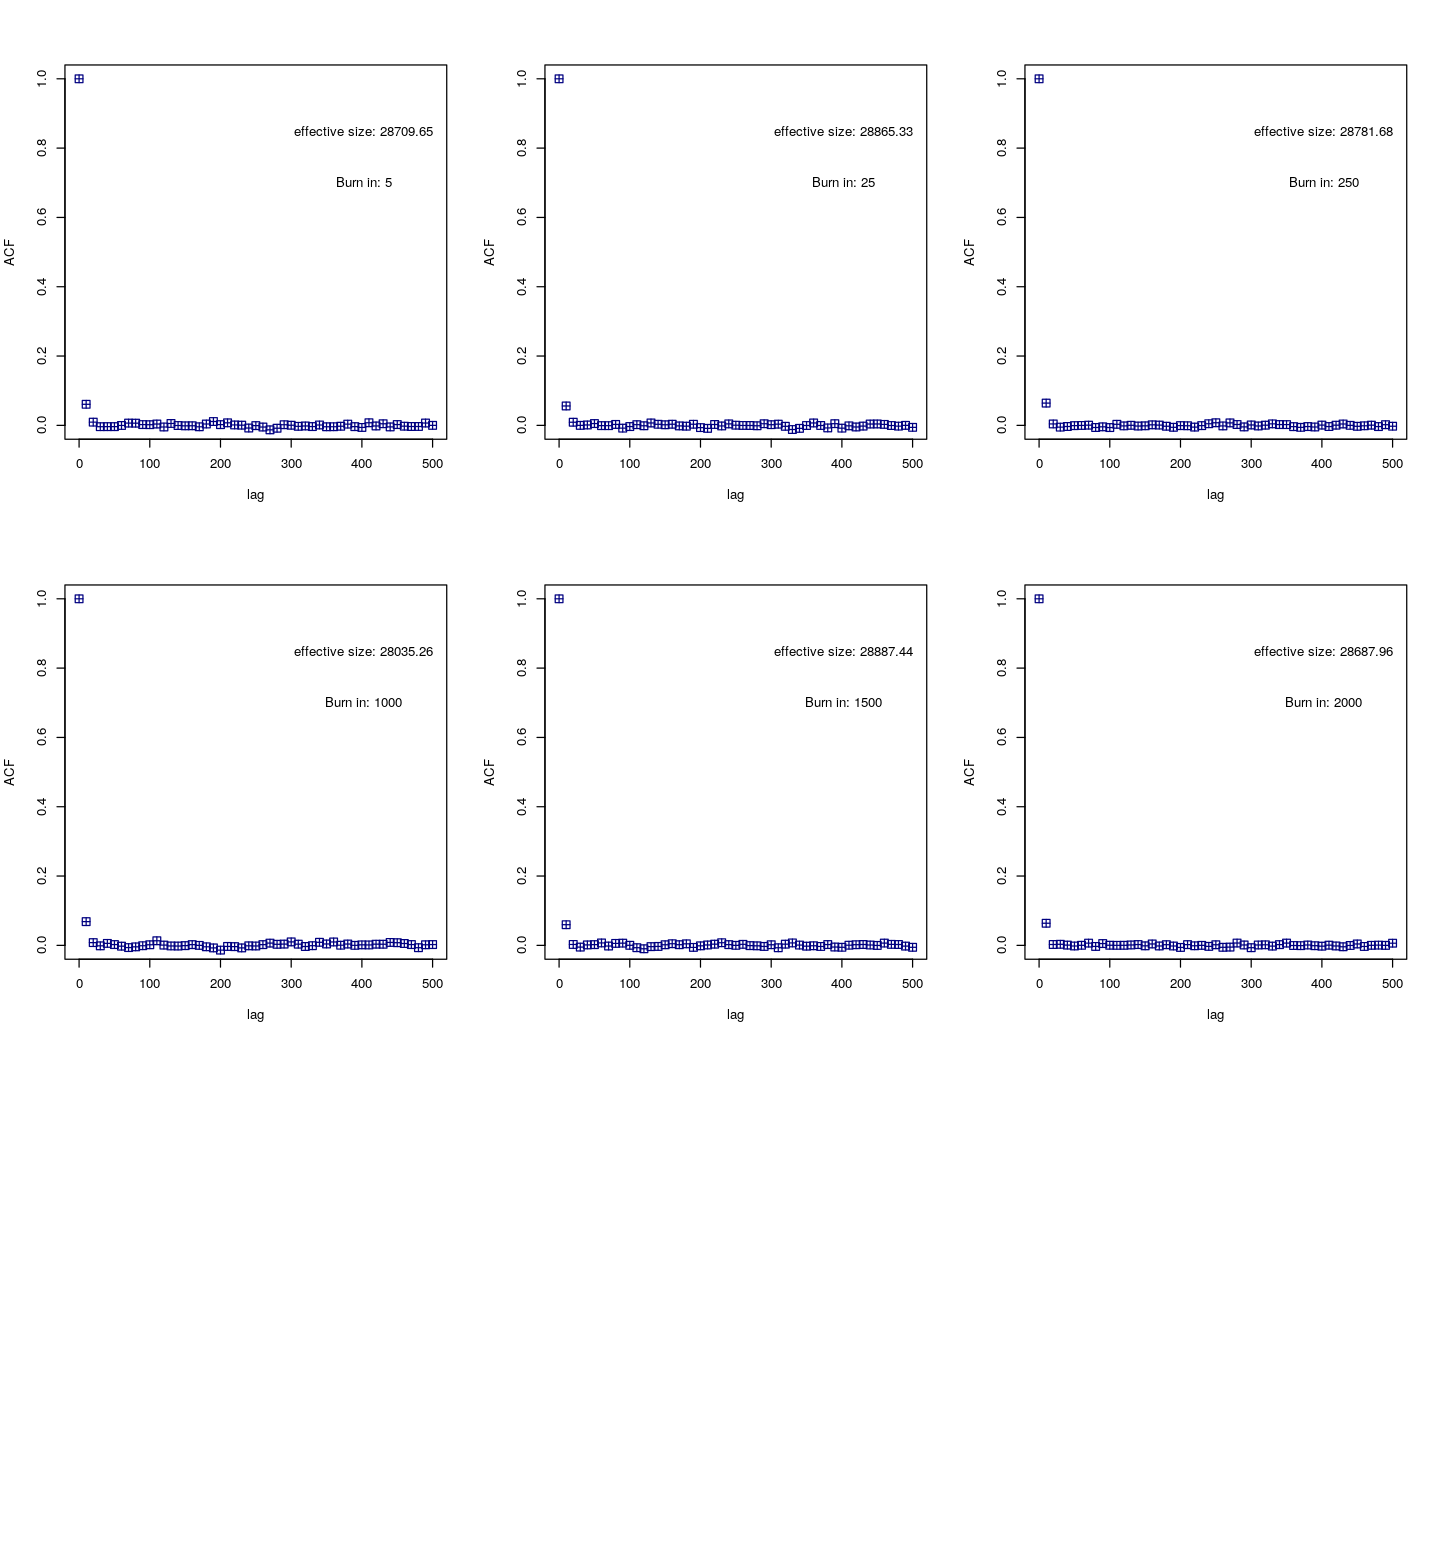

In [38]:
options(repr.plot.width=12, repr.plot.height=13)
par(mfrow=c(3,3))
burnin.vals <- c(5,25,250,1000,1500,2000)
for (burn in burnin.vals){
    update(jm , burn)
    chain <- coda.samples(jm , variable.names=c('a','b','y_1','y_2'), n.iter = 2e5, thin = 1)
    chain.df <- as.data.frame(as.mcmc(chain))
    my.lags = seq(0,500,10)
    # Here we need use as.mcmc(chain.df$b0) because
    y <- autocorr(as.mcmc(chain.df$a), lags=my.lags)
    plot(my.lags , y, ylim=c(0,1),pch=12, col='navy',
    xlab='lag', ylab='ACF', cex=1.3)
    text(400,0.85, sprintf (" effective size: %.2f", effectiveSize(as.mcmc(chain.df$a))))
    text(400,0.7, sprintf (" Burn in: %d", burn))
}

## Study of the behavoiur of the energy resolution as a function of the photon energy: inference of the other parameters <a name="p3"></a>

Now we want to infere $F$, $w_{e}$ parameters given the linear relation of ADC and $E_{\gamma}$ and given the $FWHM$.

Since the peacks are gaussian the $FWHM$ can be computed simply:
$$
FWHM = \sigma \cdot 2.355
$$.

The relation between the parameters is:
$$
FWHM = \sqrt{w_e^2+w_d^2};\quad w_d^2=2.355^2\cdot w \cdot F \cdot E_{\gamma}
$$.
As done in the linear fit we assume a gaussian error on $FWHM$:

$$
FWHM_i = \sqrt{w_e^2+(2.355^2\cdot w \cdot F \cdot E_{\gamma,i})} + \epsilon_i
$$.




In [39]:
#FWHM 
m <- 2.355
a <- a.jags
fwhm <- round((sigma.fit*a*m)^2, digits=7)

#energy
AmCsCo <- c(59.5409,661.657,1173.228,1332.492,2505.69)

df <- data.frame(E=AmCsCo,FWHM=fwhm)
rownames(df) <- c("Am-241", "Cs-137",  "C0-60.1", "C0-60.2", "C0-60.3")

options(digits=5)
df

,E,FWHM
,<dbl>,<dbl>
Am-241,59.541,12.866
Cs-137,661.657,18.492
C0-60.1,1173.228,21.291
C0-60.2,1332.492,24.149
C0-60.3,2505.690,32.623


In [40]:
data <- NULL
data$X <- df$E
data$Y <- df$FWHM
data

$X
[1]   59.541  661.657 1173.228 1332.492 2505.690

$Y
[1] 12.866 18.492 21.291 24.149 32.623

### Methods
- Even here we used the linear regression lm from R as the first method
- rJAGS to infere in an alternative way

### Linear regression

In [41]:
# lm() in R for linear regression.
regression <- lm(formula =   df$FWHM~ df$E )
regression

# Extracting coefficients
a <- regression$coefficients[2]
b <- regression$coefficients[1]


fwhm <- a * data$x+ b


Call:
lm(formula = df$FWHM ~ df$E)

Coefficients:
(Intercept)         df$E  
   12.69332      0.00802  


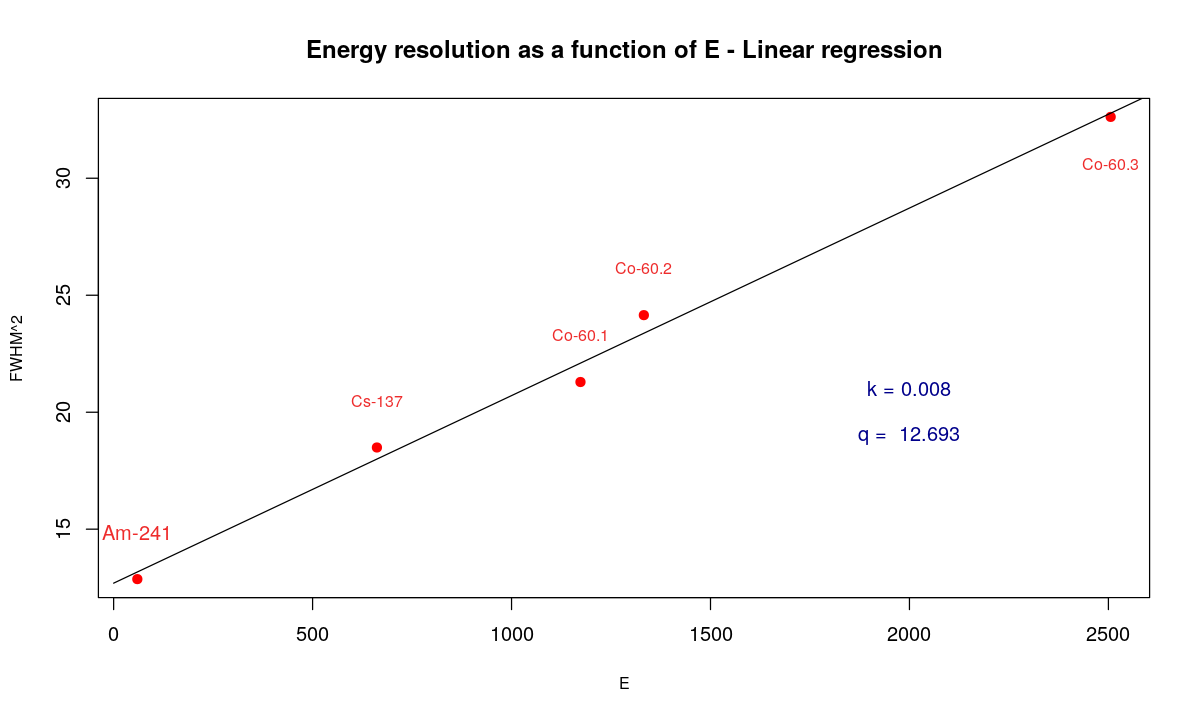

In [42]:
# Plot of Energy(keV) and FWHM 

options(repr.plot.width = 10, repr.plot.height = 6) 
plot(df$E, df$FWHM, col="red", pch=20, cex=1.5, xlab="E",cex.lab=.8,ylab='FWHM^2',
    main="Energy resolution as a function of E - Linear regression")
x <- seq(0,8000,1)
y <- a*x +b
lines(x,y)
text(df$E[1],df$FWHM[1]+2,'Am-241', col='firebrick2')
text(df$E[2],df$FWHM[2]+2,'Cs-137',cex=0.8, col='firebrick2')
text(df$E[3],df$FWHM[3]+2,'Co-60.1',cex=0.8, col='firebrick2')
text(df$E[4],df$FWHM[4]+2,'Co-60.2',cex=0.8, col='firebrick2')
text(df$E[5],df$FWHM[5]-2,'Co-60.3',cex=0.8, col='firebrick2')
text(2000,21,paste('k =',round(a,4)), col='darkblue')
text(2000,19,paste('q = ',round(b,3)), col='darkblue')



From the results of the linear regression we have that: 

$$ F \simeq 0.48$$
$$ w_e \simeq 3.56$$ 

### JAGS

In [43]:
m <- 2.355
a <- a.jags
#sigma.fit
fwhm2 <- round((sigma.fit*a*m), digits=7)
#energy
AmCsCo <- c(59.5409,661.657,1173.228,1332.492,2505.69)

df <- data.frame(E=AmCsCo,FWHM=fwhm2)
rownames(df) <- c("Am-241", "Cs-137",  "C0-60.1", "C0-60.2", "C0-60.3")

options(digits=5)
df

,E,FWHM
,<dbl>,<dbl>
Am-241,59.541,3.5870
Cs-137,661.657,4.3003
C0-60.1,1173.228,4.6142
C0-60.2,1332.492,4.9142
C0-60.3,2505.690,5.7117


In [44]:
cat("model {

    # data likelihood
    for (i in 1:length(Y)){
        Y[i] ~ dnorm(mu[i],1/sigma);
        mu[i] <- (w_e^2+(2.355^2)*0.003*X[i]*f)^0.5;
    }

    #priors
    w_e ~ dunif(0,8);
    f ~ dunif(0,1);
    sigma <- exp(logsigma)
    logsigma ~ dunif(-20,1) 

}", file='model3.bug')

init <- NULL

data <- NULL
data$X <- AmCsCo
data$Y <- fwhm2

jm <- jags.model(file='model3.bug',data, init=init)
update(jm,4000)
chain <- coda.samples(jm, c('f','w_e','sigma'), n.iter=2e5, thin=200)
print(summary(chain))

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 5
   Unobserved stochastic nodes: 3
   Total graph size: 41

Initializing model


Iterations = 5200:205000
Thinning interval = 200 
Number of chains = 1 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean     SD Naive SE Time-series SE
f     0.4873 0.0430  0.00136        0.00136
sigma 0.0192 0.0702  0.00222        0.00250
w_e   3.5452 0.1297  0.00410        0.00429

2. Quantiles for each variable:

        2.5%     25%     50%    75% 97.5%
f     0.4161 0.46801 0.48582 0.5048 0.572
sigma 0.0022 0.00481 0.00828 0.0157 0.093
w_e   3.2984 3.49831 3.54978 3.5986 3.758



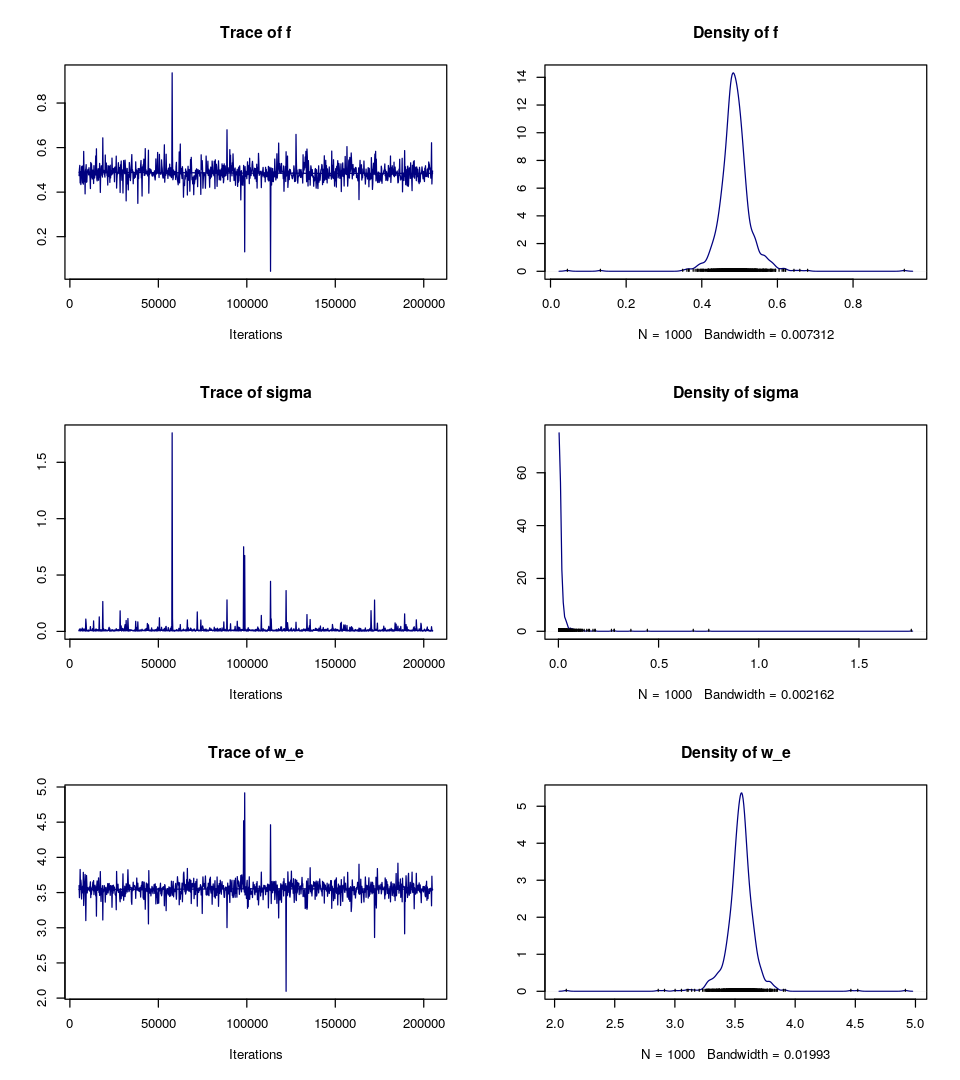

In [45]:
options(repr.plot.width=8, repr.plot.height=9)
plot(chain , col="navy")

In [46]:
sch <- summary(chain)
sch$statistics[,1:2]

sch$quantiles

#so the 95% cred interval is 2.5%-97.5%
cat('95% cred. interval: \n')
cat('f: ',sch$quantiles[1,1],'-',sch$quantiles[1,5],'\n')
cat('we: ',sch$quantiles[3,1],'-',sch$quantiles[3,5],'\n')
cat('sigma: ',sch$quantiles[2,1],'-',sch$quantiles[2,5],'\n')

,Mean,SD
f,0.487263,0.043028
sigma,0.019212,0.070206
w_e,3.545202,0.129688


,2.5%,25%,50%,75%,97.5%
f,0.4160648,0.4680129,0.4858178,0.504810,0.571757
sigma,0.0021992,0.0048097,0.0082805,0.015689,0.092951
w_e,3.2983911,3.4983060,3.5497836,3.598589,3.757662


95% cred. interval: 
f:  0.41606 - 0.57176 
we:  3.2984 - 3.7577 
sigma:  0.0021992 - 0.092951 


In [47]:
ff <- sch$statistics[1,1]
sigma <- sch$statistics[2,1]
w_e <- sch$statistics[3,1]
ff.cred <- c(sch$quantiles[1,1],sch$quantiles[1,5])
w_e.cred <- c(sch$quantiles[3,1],sch$quantiles[3,5])

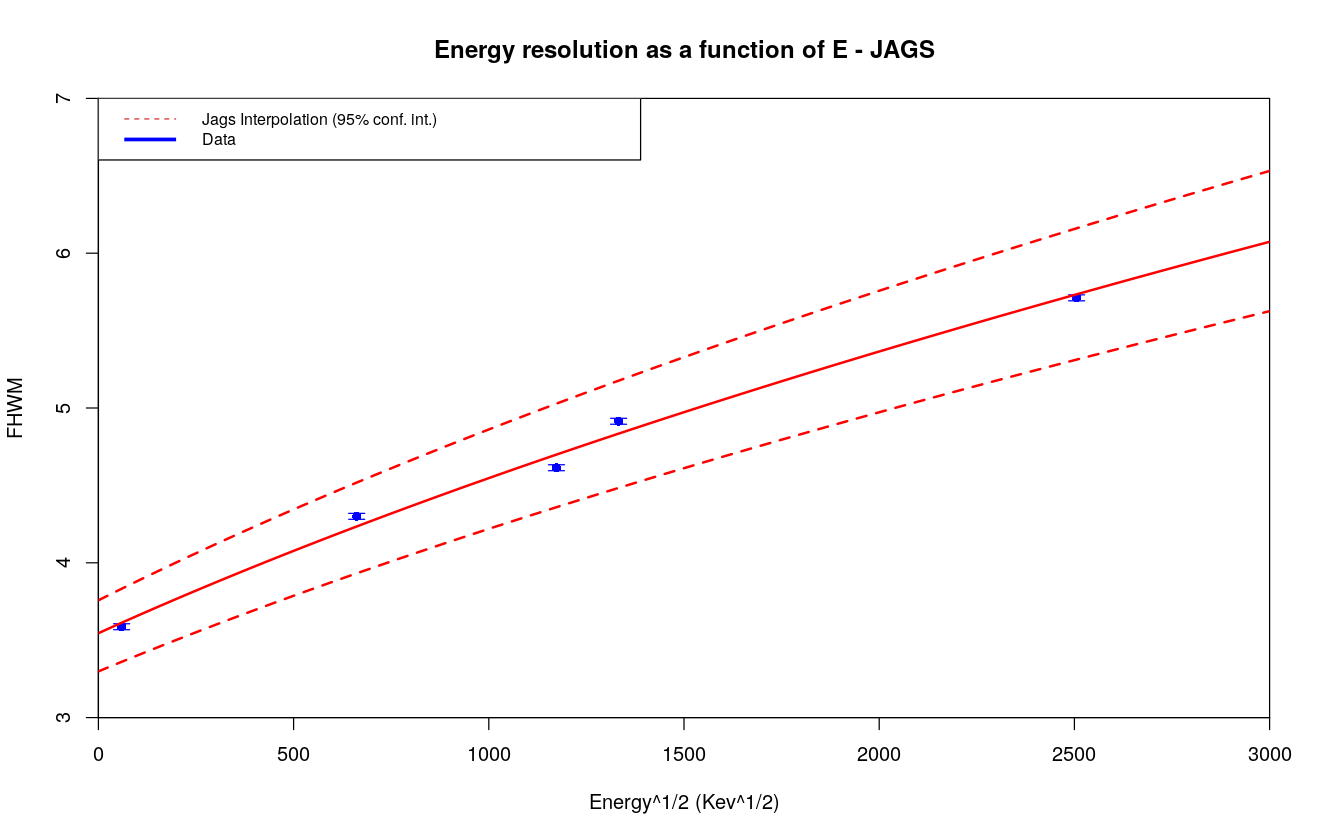

In [48]:
options(repr.plot.width=11, repr.plot.height=7)
plotCI(data$X, data$Y, xlim=c(0,3000), ylim=c(3,7), xaxs="i", yaxs="i",ylab="FHWM",xlab="Energy^1/2 (Kev^1/2)",
       main="Energy resolution as a function of E - JAGS",
       uiw=sigma, gap=0, col='blue',pch=16)
#abline(a=q, b=ff*2.355^2*0.003, lw=2, col='firebrick3')
#abline(a=q.cred[1], b=ff.cred[1]*2.355^2*0.003, lw=2, col='firebrick3',lty=2)
#abline(a=q.cred[2], b=ff.cred[2]*2.355^2*0.003, lw=2, col='firebrick3',lty=2)

xx <- 0:3000
yy <- (w_e^2+(2.355^2)*0.003*xx*ff)^0.5
yy_up <- (w_e.cred[2]^2+(2.355^2)*0.003*xx*ff.cred[2])^0.5
yy_down <- (w_e.cred[1]^2+(2.355^2)*0.003*xx*ff.cred[1])^0.5

lines(xx,yy,'l',lwd=2,col='red')
lines(xx,yy_up,'l',lwd=2,col='red',lty=2)
lines(xx,yy_down,'l',lwd=2,col='red',lty=2)

                   
text(2400,1,paste('F =',round(ff,2),'+-',round(sch$statistics[1,2],3)), col='darkblue',cex=1.2)
text(2400,0.6,paste('w_e=',round(q,2),'+-',round(sch$statistics[3,2],2)), col='darkblue',cex=1.2)
legend('topleft', legend=c('Jags Interpolation (95% conf. int.)','Data'), 
       col=c('firebrick3','blue'),lty=c(2,1,1),lwd=c(1,3,3), cex=0.8)




From the results of the the JAGS fit we have that: 

$$ F \simeq 0.48 \pm 0.04 $$
$$ w_e \simeq 3.54 \pm 0.12$$ 